In [1]:
import sys
sys.path.append('..')

In [2]:
from pcd_dataset import PointCloudDataset
from plane_detector import StructuralRANSAC
from semantic_segmentation import SemanticSegmentor
from pointnet_utils import PointnetInference
import yaml
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from scipy.ndimage import label as nd_label
from scipy.signal import find_peaks
import shapely
from shapely import MultiPoint, Polygon
from simplification.cutil import simplify_coords_vw
from scipy.spatial import ConvexHull

In [3]:
FILE = "../data/alex1.ply"

In [4]:
with open('../config.yaml') as f:
    config = yaml.safe_load(f)

In [5]:
s_val = PointCloudDataset(FILE)

In [6]:
sem_seg = SemanticSegmentor(s_val, StructuralRANSAC, PointnetInference, config)

/Users/dmytroivanov/projects/o3d/notebooks/../pcd_dataset.py:351: RuntimeWarning: divide by zero encountered in matmul
  points_xyz = points_xyz @ R_yup_to_zup.T
/Users/dmytroivanov/projects/o3d/notebooks/../pcd_dataset.py:351: RuntimeWarning: overflow encountered in matmul
  points_xyz = points_xyz @ R_yup_to_zup.T
/Users/dmytroivanov/projects/o3d/notebooks/../pcd_dataset.py:351: RuntimeWarning: invalid value encountered in matmul
  points_xyz = points_xyz @ R_yup_to_zup.T


In [7]:
# sem_seg.visualize_pcd()

In [8]:
# sem_seg.ransac_segment()

In [9]:
# sem_seg.ransac_segmentor.visualize_segments()

In [10]:
points = sem_seg.points[:, :3]

### BY CEILING

In [11]:
from detect_ceiling import detect_ceiling_peaks, extract_ceiling_levels, refine_all_ceiling_levels
from detect_floor import *
from detect_walls import *


DETECT CEILING PEAKS
Found 3 peaks

Top 10 peaks by height:
ID    Height (m)   Points       Type           
──────────────────────────────────────────────────
0     1.125        4,514        CEILING ✓      
1     0.625        2,232        CEILING ✓      
2     -1.815       19,806       FLOOR          


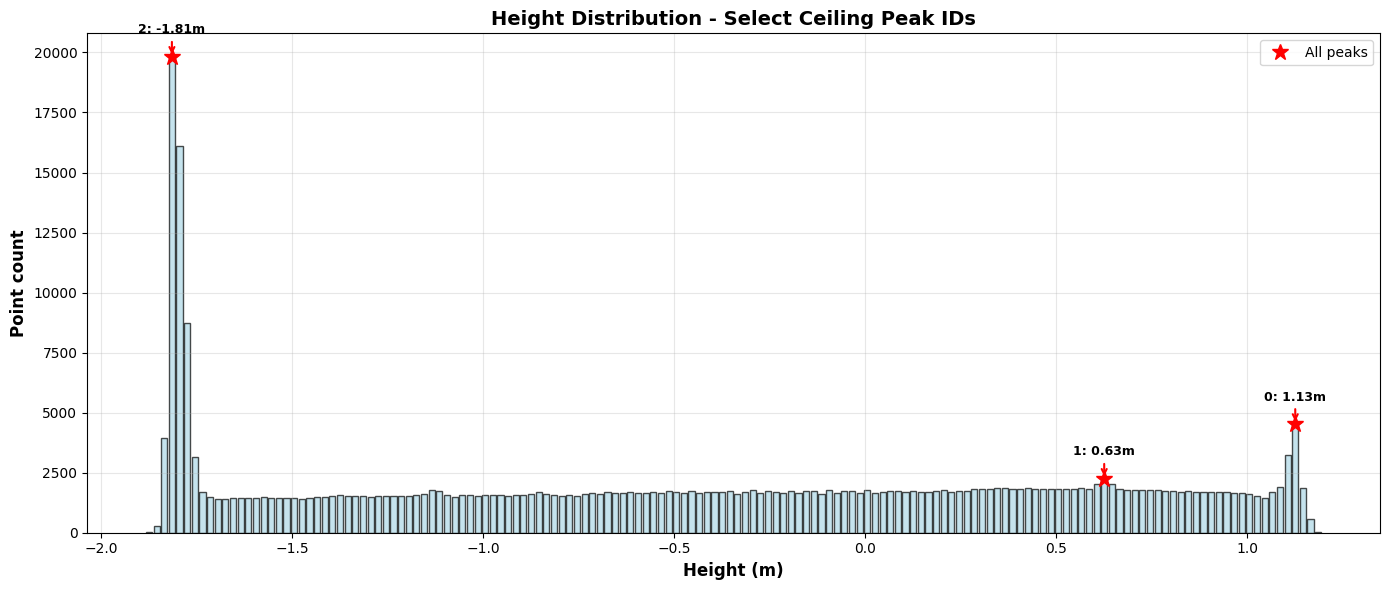


✓ Inspect the plot and choose ceiling peak IDs
  Example: If peaks 0 and 1 are ceilings, use: [0, 1]


In [12]:
step1_result = detect_ceiling_peaks(points, show_top_n=10)


EXTRACT CEILING LEVELS
✓ Ceiling level 0: 1.125m with 16,095 points
✓ Ceiling level 1: 0.625m with 19,044 points


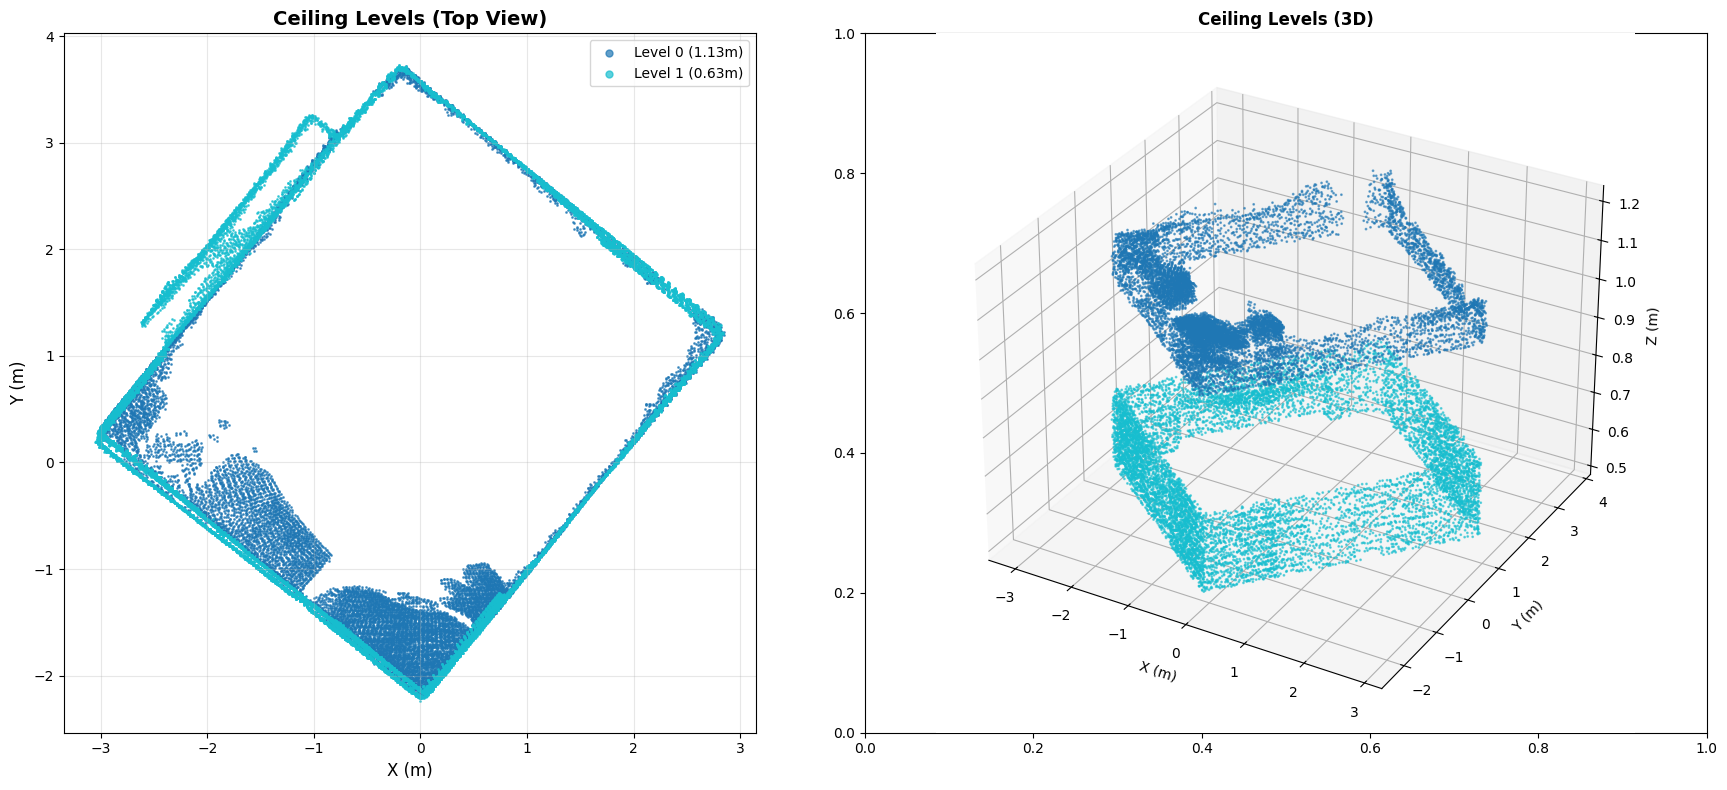


✓ Extracted 2 ceiling level(s)


In [13]:
ceiling_levels = extract_ceiling_levels(
    step1_result,
    selected_peak_ids=[0, 1],
    thickness=0.10
)

In [14]:
all_ceiling_points = np.vstack([i["points"] for i in ceiling_levels])

In [15]:
ceiling_points_2d = all_ceiling_points[:, :2]

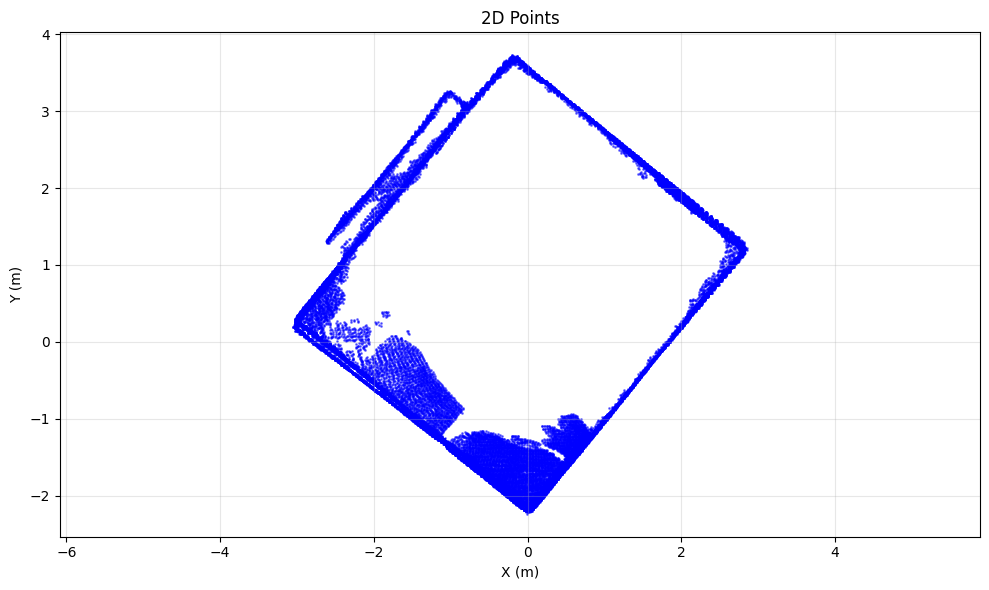

In [16]:
visualize_2d_points(ceiling_points_2d, downsample=1)

In [17]:
refined_ceiling_levels = refine_all_ceiling_levels(
    ceiling_levels,
    distance_threshold=0.1
)


REFINING ALL CEILING LEVELS

--- Level 0 (Height: 1.125m) ---

RANSAC PLANE REFINEMENT
Input points: 16,095
Distance threshold: 0.1m

✓ Plane equation: 0.0017x + 0.0062y + 1.0000z + -1.0992 = 0
✓ Inliers: 16,095 / 16,095 (100.0%)
✓ Outliers removed: 0 (0.0%)

--- Level 1 (Height: 0.625m) ---

RANSAC PLANE REFINEMENT
Input points: 19,044
Distance threshold: 0.1m

✓ Plane equation: -0.0036x + -0.0043y + 1.0000z + -0.6173 = 0
✓ Inliers: 17,108 / 19,044 (89.8%)
✓ Outliers removed: 1,936 (10.2%)

REFINEMENT SUMMARY
Level 0 @ 1.13m:
  Original: 16,095 points
  Cleaned:  16,095 points
  Removed:  0 (0.0%)
Level 1 @ 0.63m:
  Original: 19,044 points
  Cleaned:  17,108 points
  Removed:  1,936 (10.2%)

Total across all levels:
  Original: 35,139 points
  Cleaned:  33,203 points
  Removed:  1,936 (5.5%)


In [18]:
all_clean_ceiling_points = np.vstack([
    level['points'] for level in refined_ceiling_levels
])

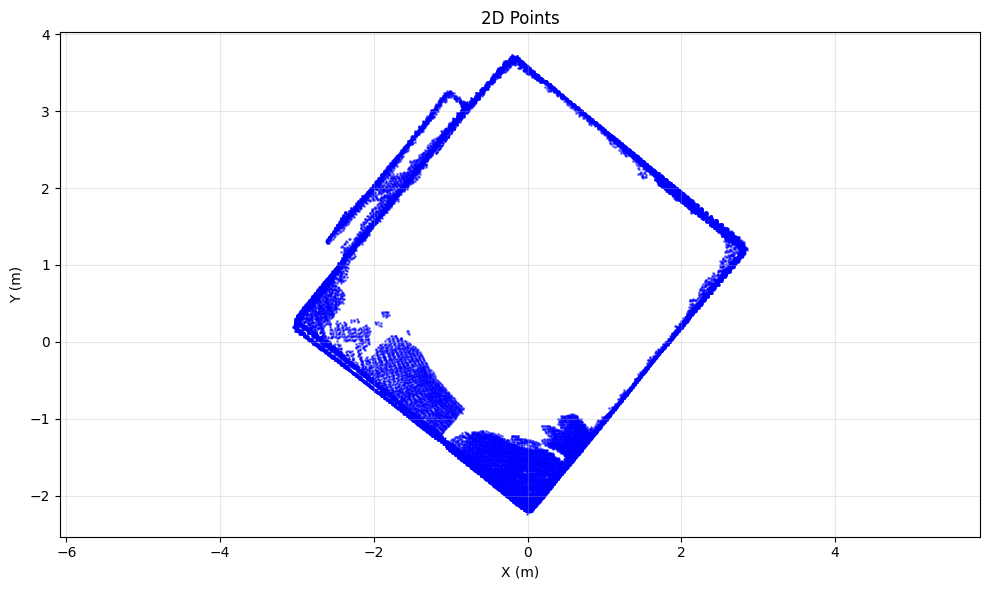

In [19]:
ceiling_points_2d = all_clean_ceiling_points[: , :2]

visualize_2d_points(ceiling_points_2d)

In [44]:
def point_to_line_distance(point, line_start, line_end):
    """
    Calculate perpendicular distance from point to line segment
    
    Parameters:
    -----------
    point : np.ndarray (2,)
        Point coordinates [x, y]
    line_start : np.ndarray (2,)
        Line start point [x, y]
    line_end : np.ndarray (2,)
        Line end point [x, y]
    
    Returns:
    --------
    distance : float
        Perpendicular distance in meters
    """
    
    # Vector from line_start to line_end
    line_vec = line_end - line_start
    line_length = np.linalg.norm(line_vec)
    
    if line_length < 1e-10:  # Degenerate line
        return np.linalg.norm(point - line_start)
    
    # Normalized line direction
    line_dir = line_vec / line_length
    
    # Vector from line_start to point
    point_vec = point - line_start
    
    # Project point onto line
    projection_length = np.dot(point_vec, line_dir)
    
    # Perpendicular vector
    perpendicular = point_vec - projection_length * line_dir
    
    return np.linalg.norm(perpendicular)

In [50]:
def fit_line_to_points(points):
    """
    Fit line through points and compute fitting error
    
    Parameters:
    -----------
    points : np.ndarray (N, 2)
        Point coordinates
    
    Returns:
    --------
    line_start : np.ndarray (2,)
        Best fit line start (first point)
    line_end : np.ndarray (2,)
        Best fit line end (last point)
    max_error : float
        Maximum perpendicular distance of any point from line
    """
    
    if len(points) < 2:
        return points[0], points[0], 0.0
    
    # Simple approach: line from first to last point
    line_start = points[0]
    line_end = points[-1]
    
    # Compute max error
    max_error = 0.0
    for point in points[1:-1]:  # Skip endpoints
        dist = point_to_line_distance(point, line_start, line_end)
        max_error = max(max_error, dist)
    
    return line_start, line_end, max_error

In [22]:
def detect_wall_segments(polygon_points, tolerance=0.02, min_segment_length=0.10):
    """
    Detect straight wall segments from concave hull polygon
    
    Uses iterative collinearity checking: adds points to current segment
    while they remain within tolerance of fitted line.
    
    Parameters:
    -----------
    polygon_points : np.ndarray (N, 2)
        Ordered polygon vertices from concave hull (closed: first=last)
    tolerance : float
        Maximum perpendicular distance from fitted line (meters)
        Default: 0.02m (2cm) for high accuracy
    min_segment_length : float
        Minimum wall length to keep (meters)
        Default: 0.10m (filter out tiny segments)
    
    Returns:
    --------
    segments : list of dict
        Each segment contains:
        - 'start': np.ndarray (2,) - segment start point
        - 'end': np.ndarray (2,) - segment end point
        - 'length': float - wall length in meters
        - 'angle': float - wall orientation (0-360 degrees from +X axis)
        - 'point_indices': np.ndarray - which polygon points belong to segment
        - 'num_points': int - how many points in this segment
        - 'max_deviation': float - maximum deviation from line
    """
    
    print(f"\n{'='*70}")
    print(f"WALL SEGMENT DETECTION")
    print(f"{'='*70}")
    print(f"Input polygon: {len(polygon_points)} vertices")
    print(f"Tolerance: {tolerance}m ({tolerance*100:.1f}cm)")
    print(f"Min segment length: {min_segment_length}m")
    
    # Remove duplicate last point if polygon is closed
    if np.allclose(polygon_points[0], polygon_points[-1]):
        polygon_points = polygon_points[:-1]
        print(f"Removed duplicate closing vertex → {len(polygon_points)} vertices")
    
    n_points = len(polygon_points)
    segments = []
    
    i = 0  # Current starting point
    
    while i < n_points:
        # Start new segment at point i
        segment_start_idx = i
        segment_indices = [i]
        
        # Try to extend segment by adding more points
        j = i + 1
        
        while j < n_points:
            # Get current segment points (from i to j inclusive)
            current_indices = list(range(i, j + 1))
            current_points = polygon_points[current_indices]
            
            # Fit line and check error
            line_start, line_end, max_error = fit_line_to_points(current_points)
            
            if max_error <= tolerance:
                # Point j fits the line, add it to segment
                segment_indices = current_indices
                j += 1
            else:
                # Point j doesn't fit, stop extending
                break
        
        # Also check wrap-around for last segment
        if i == 0:
            # Try extending backwards from end of polygon
            j = n_points - 1
            while j > segment_indices[-1]:
                # Check if wrapping around maintains collinearity
                wrap_indices = list(range(i, segment_indices[-1] + 1)) + [j]
                wrap_points = polygon_points[wrap_indices]
                
                line_start, line_end, max_error = fit_line_to_points(wrap_points)
                
                if max_error <= tolerance:
                    segment_indices = wrap_indices
                    j -= 1
                else:
                    break
        
        # Finalize segment
        if len(segment_indices) >= 2:
            seg_points = polygon_points[segment_indices]
            seg_start = seg_points[0]
            seg_end = seg_points[-1]
            seg_length = np.linalg.norm(seg_end - seg_start)
            
            # Compute angle (from +X axis, counter-clockwise)
            dx = seg_end[0] - seg_start[0]
            dy = seg_end[1] - seg_start[1]
            angle_rad = np.arctan2(dy, dx)
            angle_deg = np.degrees(angle_rad) % 360
            
            # Compute max deviation
            _, _, max_deviation = fit_line_to_points(seg_points)
            
            # Only keep if long enough
            if seg_length >= min_segment_length:
                segments.append({
                    'start': seg_start,
                    'end': seg_end,
                    'length': seg_length,
                    'angle': angle_deg,
                    'point_indices': np.array(segment_indices),
                    'num_points': len(segment_indices),
                    'max_deviation': max_deviation
                })
        
        # Move to next segment
        i = segment_indices[-1] + 1
    
    # Summary
    print(f"\n{'='*70}")
    print(f"DETECTED SEGMENTS")
    print(f"{'='*70}")
    print(f"Total segments: {len(segments)}")
    print(f"\n{'Seg':<5} {'Length':<10} {'Angle':<10} {'Points':<10} {'Max Dev':<10}")
    print(f"{'─'*50}")
    
    total_length = 0.0
    for i, seg in enumerate(segments, 1):
        print(f"{i:<5} {seg['length']:<10.3f} {seg['angle']:<10.1f} "
              f"{seg['num_points']:<10} {seg['max_deviation']:<10.4f}")
        total_length += seg['length']
    
    print(f"\n✓ Total perimeter (sum of segments): {total_length:.3f}m")
    
    # Compute area from original polygon
    polygon_closed = np.vstack([polygon_points, polygon_points[0]])
    area = compute_polygon_area(polygon_closed)
    print(f"✓ Polygon area: {area:.3f}m²")
    
    return segments

In [135]:
def compute_polygon_area(polygon_points):
    """
    Compute area of polygon using shoelace formula
    
    Parameters:
    -----------
    polygon_points : np.ndarray (N, 2)
        Closed polygon (first point = last point)
    
    Returns:
    --------
    area : float
        Polygon area in m²
    """
    
    x = polygon_points[:, 0]
    y = polygon_points[:, 1]
    
    # Shoelace formula
    area = 0.5 * np.abs(np.dot(x[:-1], y[1:]) - np.dot(x[1:], y[:-1]))
    
    return area

In [136]:
def merge_collinear_segments(segments, angle_tolerance=2.0, gap_tolerance=0.05):
    """
    Merge adjacent segments that are collinear (on same line)
    
    Sometimes the detector splits one wall into multiple segments.
    This function merges them back together.
    
    Parameters:
    -----------
    segments : list of dict
        Detected segments
    angle_tolerance : float
        Maximum angle difference to consider collinear (degrees)
    gap_tolerance : float
        Maximum gap between segments to merge (meters)
    
    Returns:
    --------
    merged_segments : list of dict
        Merged segments
    """
    
    if len(segments) < 2:
        return segments
    
    print(f"\n{'='*70}")
    print(f"MERGING COLLINEAR SEGMENTS")
    print(f"{'='*70}")
    print(f"Angle tolerance: {angle_tolerance}°")
    print(f"Gap tolerance: {gap_tolerance}m")
    
    merged = []
    i = 0
    
    while i < len(segments):
        current = segments[i]
        
        # Try to merge with next segment
        while i + 1 < len(segments):
            next_seg = segments[i + 1]
            
            # Check if angles are similar
            angle_diff = abs(current['angle'] - next_seg['angle'])
            angle_diff = min(angle_diff, 360 - angle_diff)  # Handle wraparound
            
            # Check if endpoints are close
            gap = np.linalg.norm(current['end'] - next_seg['start'])
            
            # Check collinearity: is next segment on same line?
            dist = point_to_line_distance(next_seg['end'], current['start'], current['end'])
            
            if angle_diff <= angle_tolerance and gap <= gap_tolerance and dist <= 0.03:
                # Merge segments
                print(f"  Merging segment {i+1} and {i+2}")
                current = {
                    'start': current['start'],
                    'end': next_seg['end'],
                    'length': np.linalg.norm(next_seg['end'] - current['start']),
                    'angle': current['angle'],  # Keep first angle
                    'point_indices': np.concatenate([current['point_indices'], 
                                                     next_seg['point_indices']]),
                    'num_points': current['num_points'] + next_seg['num_points'],
                    'max_deviation': max(current['max_deviation'], next_seg['max_deviation'])
                }
                i += 1  # Skip next segment
            else:
                break
        
        merged.append(current)
        i += 1
    
    print(f"\n✓ Reduced from {len(segments)} to {len(merged)} segments")
    
    return merged

In [137]:
def visualize_wall_segments(polygon_points, segments, figsize=(14, 12)):
    """
    Visualize detected wall segments with labels
    
    Parameters:
    -----------
    polygon_points : np.ndarray (N, 2)
        Original polygon vertices
    segments : list of dict
        Detected segments
    """
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot polygon
    poly_closed = np.vstack([polygon_points, polygon_points[0]])
    ax.plot(poly_closed[:, 0], poly_closed[:, 1], 'o-', 
            color='red', markersize=3, linewidth=1, alpha=0.5, 
            label='Concave hull vertices')
    
    # Plot detected segments
    colors = plt.cm.tab10(np.linspace(0, 1, len(segments)))
    
    for i, seg in enumerate(segments):
        color = colors[i]
        
        # Draw segment line
        ax.plot([seg['start'][0], seg['end'][0]], 
                [seg['start'][1], seg['end'][1]], 
                '-', color=color, linewidth=3, alpha=0.8)
        
        # Draw arrow in middle showing direction
        mid_x = (seg['start'][0] + seg['end'][0]) / 2
        mid_y = (seg['start'][1] + seg['end'][1]) / 2
        
        dx = seg['end'][0] - seg['start'][0]
        dy = seg['end'][1] - seg['start'][1]
        length = seg['length']
        
        # Small arrow
        arrow_scale = 0.1
        ax.arrow(mid_x - dx*arrow_scale/2, mid_y - dy*arrow_scale/2,
                dx*arrow_scale, dy*arrow_scale,
                head_width=0.1, head_length=0.05, 
                fc=color, ec=color, alpha=0.7)
        
        # Label with segment number and length
        label_offset = 0.2
        # Perpendicular offset for label
        perp_x = -dy / length * label_offset
        perp_y = dx / length * label_offset
        
        ax.text(mid_x + perp_x, mid_y + perp_y, 
                f"{i+1}: {seg['length']:.2f}m\n{seg['angle']:.0f}°",
                fontsize=9, fontweight='bold',
                ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.3', 
                         facecolor=color, alpha=0.7, edgecolor='black'))
    
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('X (m)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Y (m)', fontsize=12, fontweight='bold')
    ax.set_title(f'Detected Wall Segments ({len(segments)} walls)', 
                fontsize=14, fontweight='bold')
    ax.legend(loc='upper right')
    
    plt.tight_layout()
    
    return fig

In [168]:
from simplification.cutil import simplify_coords_vw
import numpy as np

# Step 1: Get concave hull
concave = shapely.concave_hull(multi_point, ratio=0.05)
polygon_points = np.array(concave.exterior.coords)

print(f"Original vertices: {len(polygon_points)}")

# Step 2: Apply Visvalingam-Whyatt
# Try different thresholds to find best balance
for threshold in [0.0001, 0.0005, 0.001, 0.005, 0.01]:
    simplified = simplify_coords_vw(polygon_points, epsilon=threshold)
    
    print(f"\nThreshold: {threshold} m²")
    print(f"  Vertices: {len(polygon_points)} → {len(simplified)}")
    
    # Test 10-point deviation
    if len(simplified) >= 10:
        # from wall_segment_detection import fit_line_to_points
        _, _, err = fit_line_to_points(simplified[0:10])
        print(f"  10-point error: {err*100:.1f}cm")
    
    # Try segment detection
    segments = detect_wall_segments(
        simplified,
        tolerance=0.10,
        min_segment_length=0.20
    )
    
    print(f"  Segments detected: {len(segments)}")
    
    if len(segments) > 4:  # If we get more than 4 walls
        merged = merge_collinear_segments(segments)
        total_perim = sum(seg['length'] for seg in merged)
        print(f"  After merging: {len(merged)} walls")
        print(f"  Total perimeter: {total_perim:.2f}m")
        
        # Visualize
        fig = visualize_wall_segments(simplified, merged)
        plt.title(f'V-W Threshold={threshold} m² ({len(merged)} walls)')
        plt.show()

Original vertices: 175

Threshold: 0.0001 m²
  Vertices: 175 → 121
  10-point error: 17.8cm

WALL SEGMENT DETECTION
Input polygon: 121 vertices
Tolerance: 0.1m (10.0cm)
Min segment length: 0.2m
Removed duplicate closing vertex → 120 vertices

DETECTED SEGMENTS
Total segments: 0

Seg   Length     Angle      Points     Max Dev   
──────────────────────────────────────────────────

✓ Total perimeter (sum of segments): 0.000m
✓ Polygon area: 10.487m²
  Segments detected: 0

Threshold: 0.0005 m²
  Vertices: 175 → 84
  10-point error: 16.6cm

WALL SEGMENT DETECTION
Input polygon: 84 vertices
Tolerance: 0.1m (10.0cm)
Min segment length: 0.2m
Removed duplicate closing vertex → 83 vertices

DETECTED SEGMENTS
Total segments: 1

Seg   Length     Angle      Points     Max Dev   
──────────────────────────────────────────────────
1     0.484      227.4      5          0.0533    

✓ Total perimeter (sum of segments): 0.484m
✓ Polygon area: 10.487m²
  Segments detected: 1

Threshold: 0.001 m²
  Verti

In [169]:
simplified

array([[ 0.447334  ,  2.144724  ],
       [ 0.607524  ,  2.29853   ],
       [ 0.9822075 ,  1.9712985 ],
       [ 1.14893   ,  2.01096   ],
       [ 1.432823  ,  2.259524  ],
       [ 2.172673  ,  1.597364  ],
       [ 2.172458  ,  1.47511   ],
       [ 1.433578  ,  0.646731  ],
       [ 1.4443275 ,  0.4734925 ],
       [ 1.71852   ,  0.167019  ],
       [ 1.619163  , -0.046159  ],
       [ 1.21388   , -0.503198  ],
       [ 0.992304  , -0.691307  ],
       [ 0.341431  , -1.416711  ],
       [-0.368345  , -2.133253  ],
       [-0.652861  , -2.463685  ],
       [-0.794797  , -2.422292  ],
       [-2.05535875, -1.289164  ],
       [-2.341896  , -0.882045  ],
       [-0.946553  ,  0.65489   ],
       [ 0.447334  ,  2.144724  ]])

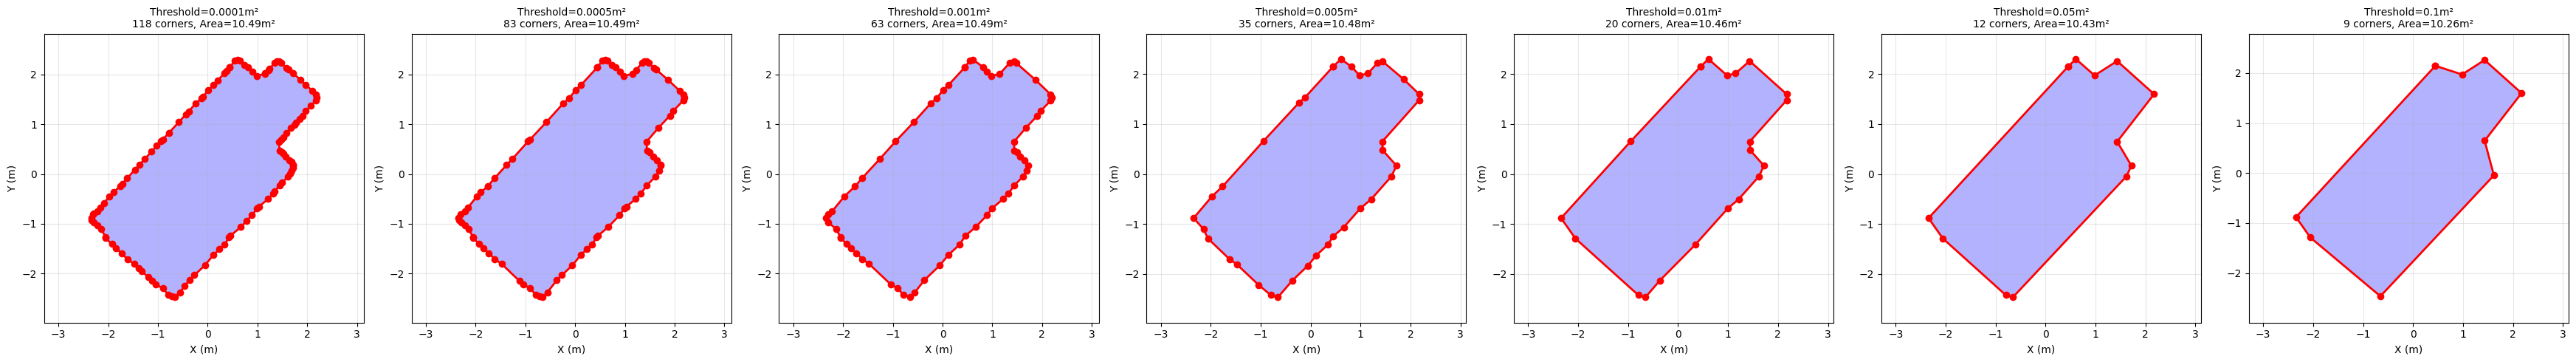


VISVALINGAM-WHYATT SIMPLIFICATION COMPARISON
Threshold (m²)  Vertices   Area (m²) 
----------------------------------------------------------------------
0.0001          118        10.49     
0.0005          83         10.49     
0.0010          63         10.49     
0.0050          35         10.48     
0.0100          20         10.46     
0.0500          12         10.43     
0.1000          9          10.26     


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Get your concave hull points
polygon_points = np.array(concave.exterior.coords)

# V-W uses "effective area" threshold (m²), not distance
# Smaller threshold = more detail, larger threshold = more simplified
thresholds = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]

fig, axes = plt.subplots(1, len(thresholds), figsize=(5*len(thresholds), 5))

for idx, threshold in enumerate(thresholds):
    ax = axes[idx]
    
    # Apply Visvalingam-Whyatt simplification
    simplified_points = simplify_coords_vw(polygon_points, epsilon=threshold)
    
    # Create polygon for area calculation
    simplified_poly = Polygon(simplified_points)
    
    # Plot
    x, y = simplified_points[:, 0], simplified_points[:, 1]
    ax.fill(x, y, alpha=0.3, fc='blue')
    ax.plot(x, y, 'r-', linewidth=2)
    ax.plot(x, y, 'ro', markersize=6)
    
    corners = len(simplified_points) - 1
    area = simplified_poly.area
    
    # # Test 10-point deviation if enough points
    # if len(simplified_points) >= 10:
    #     # from wall_segment_detection import fit_line_to_points
    #     _, _, err = fit_line_to_points(simplified_points[0:10])
    #     error_text = f'\n10-pt err: {err*100:.1f}cm'
    # else:
    #     error_text = ''
    
    ax.set_title(f'Threshold={threshold}m²\n{corners} corners, Area={area:.2f}m²',
                fontsize=10)
    ax.axis('equal')
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')

plt.tight_layout()
plt.show()

# Also print summary
print("\n" + "="*70)
print("VISVALINGAM-WHYATT SIMPLIFICATION COMPARISON")
print("="*70)
print(f"{'Threshold (m²)':<15} {'Vertices':<10} {'Area (m²)':<10}")
print("-"*70)

for threshold in thresholds:
    simplified_points = simplify_coords_vw(polygon_points, epsilon=threshold)
    poly = Polygon(simplified_points)
    
    
    print(f"{threshold:<15.4f} {len(simplified_points)-1:<10} {poly.area:<10.2f}")

In [106]:
def straighten_polyline(points, 
                       straightness_threshold=175.0,  # Degrees
                       max_deviation=0.08):            # Meters
    """
    Detect nearly-straight sequences and replace with actual straight lines
    
    This is DIFFERENT from simplification!
    
    Example:
    Input:  [P1, P2, P3, P4, P5, P6] (6 points, slightly wavy)
            P1─P2
               ╲P3
                ╲P4
                 P5─P6
    
    If P1...P4 are nearly collinear (angles ~178-180°):
    Output: [P1, P4, P5, P6] (4 points, P1-P4 is now perfectly straight)
    
    This PRESERVES the wall length (P1 to P4 distance)
    But REMOVES the waviness
    """
    
    straightened = []
    i = 0
    
    while i < len(points):
        # Start new segment
        segment_start = i
        straightened.append(points[i])
        
        # Try to extend segment while points remain nearly collinear
        j = i + 1
        
        while j < len(points) - 1:
            # Check if points [i...j+1] are nearly collinear
            
            # Method 1: Check angles
            # If angle at each point ≈ 180°, they're on same line
            
            # Method 2: Check deviation from line
            # Fit line through [i...j+1]
            # If max deviation < threshold, they're straight
            
            segment_points = points[i:j+2]
            line_start, line_end, max_dev = fit_line_to_points(segment_points)
            
            # Also check angles
            angles_ok = check_angles_nearly_straight(segment_points, straightness_threshold)
            
            if max_dev <= max_deviation and angles_ok:
                # Still straight, continue extending
                j += 1
            else:
                # No longer straight, finalize segment
                break
        
        # Finalize: Use endpoint of straight segment
        if j > i + 1:  # If we found a straight sequence
            straightened.append(points[j])
            i = j
        else:
            i += 1
    
    return np.array(straightened)

In [107]:
def check_angles_nearly_straight(points, threshold_deg=175.0):
    """
    Check if all angles in sequence are nearly 180° (straight)
    """
    if len(points) < 3:
        return True
    
    for i in range(1, len(points) - 1):
        v1 = points[i] - points[i-1]
        v2 = points[i+1] - points[i]
        
        # Compute angle
        cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-10)
        cos_angle = np.clip(cos_angle, -1.0, 1.0)
        angle_deg = np.degrees(np.arccos(cos_angle))
        
        # Check if nearly straight (180° = collinear)
        if angle_deg < threshold_deg:
            return False
    
    return True


def straighten_and_simplify(polygon_points,
                            straighten_deviation=0.08,
                            straightness_angle=175.0,
                            vw_threshold=0.001):
    """
    TWO-STAGE pipeline following IEEE paper
    
    Stage 1: Straighten (normalize polylines)
    Stage 2: Simplify (remove redundant vertices with V-W)
    """
    
    print(f"\n{'='*70}")
    print(f"TWO-STAGE POLYLINE PROCESSING")
    print(f"{'='*70}")
    
    print(f"\nOriginal: {len(polygon_points)} vertices")
    
    # STAGE 1: STRAIGHTEN
    print(f"\nStage 1: Straightening...")
    print(f"  Max deviation: {straighten_deviation}m")
    print(f"  Angle threshold: {straightness_angle}°")
    
    straightened = straighten_polyline_iterative(
        polygon_points,
        max_deviation=straighten_deviation,
        angle_threshold=straightness_angle
    )
    
    print(f"  After straightening: {len(straightened)} vertices")
    
    # STAGE 2: SIMPLIFY with V-W
    print(f"\nStage 2: Simplifying (V-W)...")
    print(f"  Threshold: {vw_threshold}m²")
    
    from simplification.cutil import simplify_coords_vw
    simplified = simplify_coords_vw(straightened, epsilon=vw_threshold)
    
    print(f"  After V-W: {len(simplified)} vertices")
    
    return simplified


def straighten_polyline_iterative(points, max_deviation=0.08, angle_threshold=175.0):
    """
    Straighten nearly-straight sequences iteratively
    """
    
    straightened = [points[0]]
    i = 0
    
    while i < len(points) - 1:
        # Try to extend from current point
        j = i + 1
        best_j = i + 1
        
        # Greedy: extend as far as possible while remaining straight
        while j < len(points):
            segment = points[i:j+1]
            
            # Check straightness
            if len(segment) >= 3:
                line_start, line_end, max_dev = fit_line_to_points(segment)
                angles_ok = check_angles_nearly_straight(segment, angle_threshold)
                
                if max_dev <= max_deviation and angles_ok:
                    best_j = j
                    j += 1
                else:
                    break
            else:
                best_j = j
                j += 1
        
        # Add endpoint of straight segment
        if best_j > i + 1:
            # Found a straight sequence, use its endpoint
            straightened.append(points[best_j])
            i = best_j
        else:
            # No straight sequence, just add next point
            straightened.append(points[i + 1])
            i += 1
    
    return np.array(straightened)

In [108]:
def detect_corners(polygon_points, min_angle_change=20.0):
    """
    Detect real corners (significant direction changes)
    
    Not every vertex is a corner!
    Corner = angle change > threshold (e.g., 20-30 degrees)
    
    Parameters:
    -----------
    polygon_points : np.ndarray (N, 2)
        Simplified polygon vertices
    min_angle_change : float
        Minimum angle change to be considered a corner (degrees)
    
    Returns:
    --------
    corners : list of dict
        Each corner:
        - 'index': int - vertex index
        - 'position': np.ndarray (2,) - (x, y)
        - 'angle': float - interior angle at corner
    """
    
    print(f"\n{'='*70}")
    print(f"CORNER DETECTION")
    print(f"{'='*70}")
    print(f"Min angle change: {min_angle_change}°")
    
    corners = []
    n = len(polygon_points)
    
    for i in range(n):
        # Get three consecutive points
        prev_idx = (i - 1) % n
        curr_idx = i
        next_idx = (i + 1) % n
        
        p_prev = polygon_points[prev_idx]
        p_curr = polygon_points[curr_idx]
        p_next = polygon_points[next_idx]
        
        # Vectors
        v1 = p_prev - p_curr
        v2 = p_next - p_curr
        
        # Angle between vectors
        cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-10)
        cos_angle = np.clip(cos_angle, -1.0, 1.0)
        angle_rad = np.arccos(cos_angle)
        angle_deg = np.degrees(angle_rad)
        
        # Interior angle
        interior_angle = 180 - angle_deg
        
        # Check if significant angle change (corner)
        if abs(angle_deg) > min_angle_change:
            corners.append({
                'index': curr_idx,
                'position': p_curr.copy(),
                'angle': interior_angle
            })
    
    print(f"\n✓ Detected {len(corners)} corners")
    
    for i, corner in enumerate(corners):
        print(f"  Corner {i+1}: ({corner['position'][0]:.2f}, {corner['position'][1]:.2f}) "
              f"@ {corner['angle']:.1f}°")
    
    return corners


def compute_wall_dimensions_from_corners(corners):
    """
    Compute wall lengths between consecutive corners
    
    This gives you the actual room dimensions!
    
    Returns:
    --------
    walls : list of dict
        Each wall:
        - 'start_corner': int
        - 'end_corner': int
        - 'length': float (meters)
        - 'angle': float (orientation in degrees)
    """
    
    print(f"\n{'='*70}")
    print(f"WALL DIMENSIONS (Corner-to-Corner)")
    print(f"{'='*70}")
    
    walls = []
    n_corners = len(corners)
    
    for i in range(n_corners):
        start_corner = corners[i]
        end_corner = corners[(i + 1) % n_corners]
        
        # Vector from start to end
        vec = end_corner['position'] - start_corner['position']
        length = np.linalg.norm(vec)
        
        # Angle
        angle_rad = np.arctan2(vec[1], vec[0])
        angle_deg = np.degrees(angle_rad) % 360
        
        walls.append({
            'start_corner': i,
            'end_corner': (i + 1) % n_corners,
            'length': length,
            'angle': angle_deg,
            'start_pos': start_corner['position'],
            'end_pos': end_corner['position']
        })
        
        print(f"Wall {i+1}: {length:.3f}m @ {angle_deg:.1f}° "
              f"(Corner {i+1} → Corner {(i+1)%n_corners + 1})")
    
    total_perimeter = sum(wall['length'] for wall in walls)
    print(f"\n✓ Total perimeter: {total_perimeter:.3f}m")
    
    return walls

In [53]:
polygon_points = np.array(concave.exterior.coords)
straightened_simplified = straighten_and_simplify(
    polygon_points,
    straighten_deviation=0.08,
    straightness_angle=170.0,
    vw_threshold=0.05
)


TWO-STAGE POLYLINE PROCESSING

Original: 173 vertices

Stage 1: Straightening...
  Max deviation: 0.08m
  Angle threshold: 170.0°
  After straightening: 173 vertices

Stage 2: Simplifying (V-W)...
  Threshold: 0.05m²
  After V-W: 13 vertices


In [54]:
polygon_points = straightened_simplified

In [55]:
corners = detect_corners(
    polygon_points,
    min_angle_change=45.0 
)


CORNER DETECTION
Min angle change: 45.0°

✓ Detected 13 corners
  Corner 1: (0.45, 2.14) @ 90.0°
  Corner 2: (0.61, 2.30) @ 85.0°
  Corner 3: (0.98, 1.97) @ 73.7°
  Corner 4: (1.43, 2.26) @ 74.4°
  Corner 5: (2.17, 1.60) @ 86.0°
  Corner 6: (1.43, 0.65) @ 68.6°
  Corner 7: (1.72, 0.17) @ 55.7°
  Corner 8: (1.62, -0.05) @ 18.2°
  Corner 9: (-0.65, -2.46) @ 63.0°
  Corner 10: (-0.79, -2.42) @ 25.7°
  Corner 11: (-2.06, -1.29) @ 12.9°
  Corner 12: (-2.34, -0.88) @ 77.8°
  Corner 13: (0.45, 2.14) @ 90.0°


In [56]:
walls = compute_wall_dimensions_from_corners(corners)


WALL DIMENSIONS (Corner-to-Corner)
Wall 1: 0.222m @ 43.8° (Corner 1 → Corner 2)
Wall 2: 0.497m @ 318.9° (Corner 2 → Corner 3)
Wall 3: 0.535m @ 32.6° (Corner 3 → Corner 4)
Wall 4: 0.993m @ 318.2° (Corner 4 → Corner 5)
Wall 5: 1.204m @ 232.1° (Corner 5 → Corner 6)
Wall 6: 0.558m @ 300.7° (Corner 6 → Corner 7)
Wall 7: 0.235m @ 245.0° (Corner 7 → Corner 8)
Wall 8: 3.318m @ 226.8° (Corner 8 → Corner 9)
Wall 9: 0.148m @ 163.7° (Corner 9 → Corner 10)
Wall 10: 1.695m @ 138.0° (Corner 10 → Corner 11)
Wall 11: 0.498m @ 125.1° (Corner 11 → Corner 12)
Wall 12: 4.116m @ 47.3° (Corner 12 → Corner 13)
Wall 13: 0.000m @ 0.0° (Corner 13 → Corner 1)

✓ Total perimeter: 14.019m


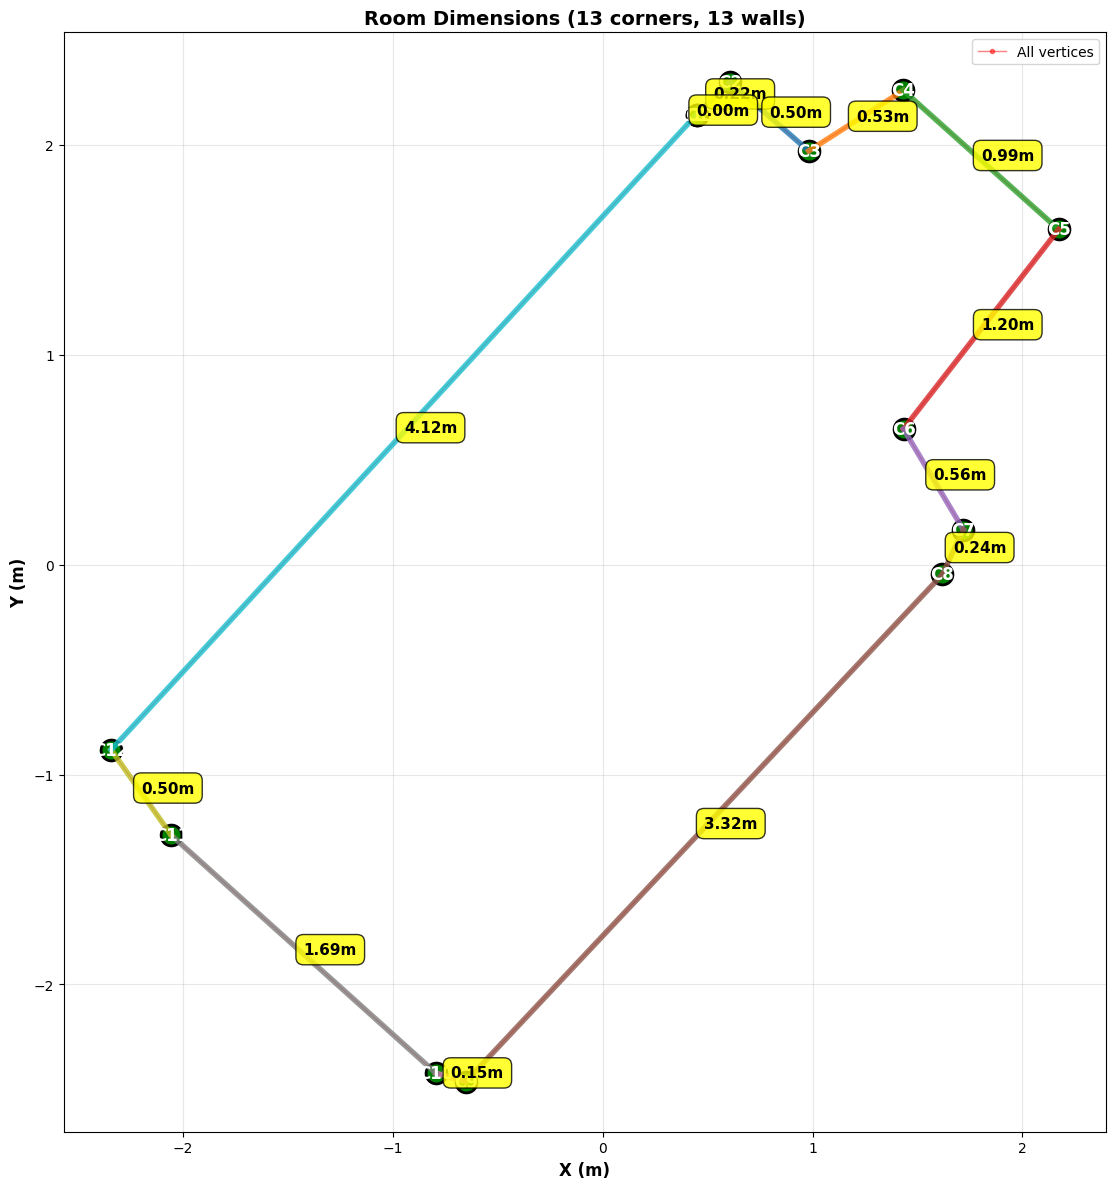

In [57]:
fig, ax = plt.subplots(figsize=(14, 12))

# Plot polygon
poly_closed = np.vstack([polygon_points, polygon_points[0]])
ax.plot(poly_closed[:, 0], poly_closed[:, 1], 'o-', 
        color='red', markersize=3, linewidth=1, alpha=0.5,
        label='All vertices')

# Mark corners with larger markers
for i, corner in enumerate(corners):
    pos = corner['position']
    ax.plot(pos[0], pos[1], 'go', markersize=15, 
            markeredgecolor='black', markeredgewidth=2)
    ax.text(pos[0], pos[1], f"C{i+1}", 
            fontsize=12, fontweight='bold', ha='center', va='center',
            color='white')

# Draw walls with dimensions
colors = plt.cm.tab10(np.linspace(0, 1, len(walls)))
for i, wall in enumerate(walls):
    # Draw wall
    ax.plot([wall['start_pos'][0], wall['end_pos'][0]],
            [wall['start_pos'][1], wall['end_pos'][1]],
            '-', color=colors[i], linewidth=4, alpha=0.8)
    
    # Label with dimension
    mid_x = (wall['start_pos'][0] + wall['end_pos'][0]) / 2
    mid_y = (wall['start_pos'][1] + wall['end_pos'][1]) / 2
    
    ax.text(mid_x, mid_y, f"{wall['length']:.2f}m",
            fontsize=11, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5', 
                     facecolor='yellow', alpha=0.8, edgecolor='black'))

ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
ax.set_xlabel('X (m)', fontsize=12, fontweight='bold')
ax.set_ylabel('Y (m)', fontsize=12, fontweight='bold')
ax.set_title(f'Room Dimensions ({len(corners)} corners, {len(walls)} walls)', 
            fontsize=14, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

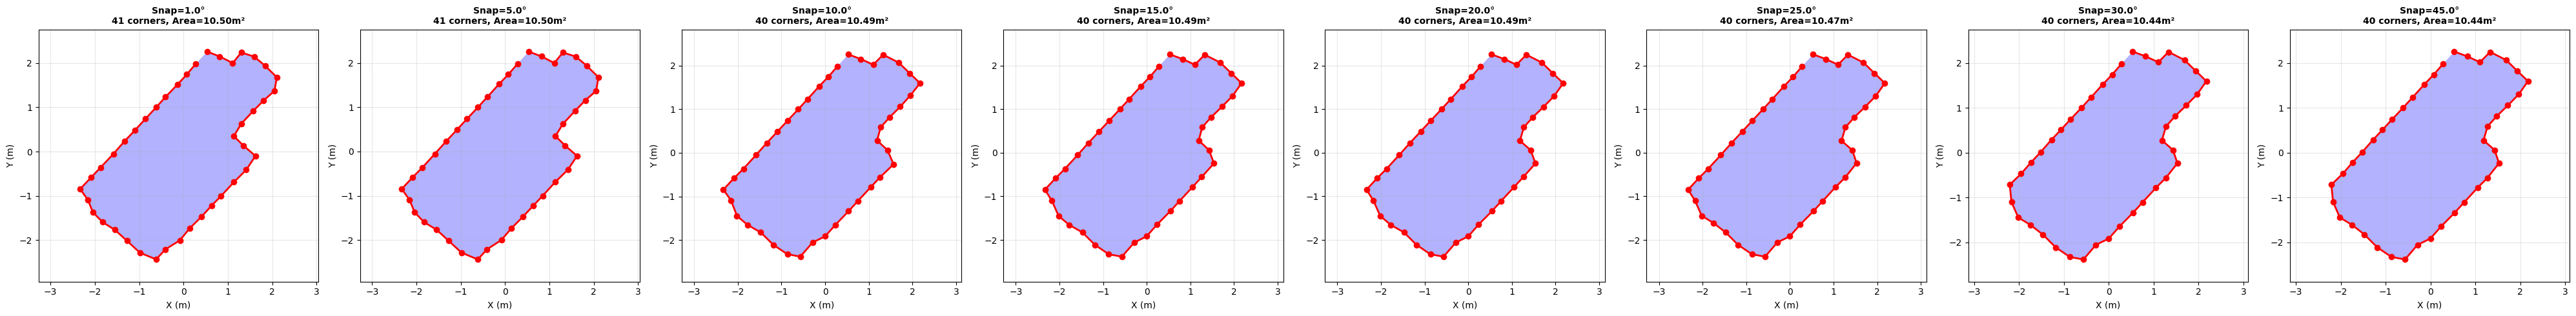


WANG-MÜLLER SIMPLIFICATION COMPARISON
Snap Threshold (°)   Vertices   Area (m²)    Perimeter (m)  
----------------------------------------------------------------------
1.0                  41         10.50        14.17          
5.0                  41         10.50        14.18          
10.0                 40         10.49        14.06          
15.0                 40         10.49        14.03          
20.0                 40         10.49        14.04          
25.0                 40         10.47        14.03          
30.0                 40         10.44        13.94          
45.0                 40         10.44        13.94          

RECOMMENDED: Snap threshold = 15-20° for best balance


In [392]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from scipy.signal import find_peaks


def detect_dominant_orientations(polygon_points, num_orientations=4, angular_bins=180):
    """Detect dominant wall orientations using histogram"""
    n = len(polygon_points)
    edge_angles = []
    edge_lengths = []
    
    for i in range(n):
        p1 = polygon_points[i]
        p2 = polygon_points[(i + 1) % n]
        vec = p2 - p1
        length = np.linalg.norm(vec)
        
        if length > 0.01:
            angle = np.arctan2(vec[1], vec[0])
            angle = angle % np.pi  # Normalize to [0, π)
            edge_angles.append(angle)
            edge_lengths.append(length)
    
    edge_angles = np.array(edge_angles)
    edge_lengths = np.array(edge_lengths)
    
    hist, bin_edges = np.histogram(edge_angles, bins=angular_bins, 
                                   range=(0, np.pi), weights=edge_lengths)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    peaks, _ = find_peaks(hist, prominence=np.max(hist) * 0.1)
    peak_prominences = hist[peaks]
    sorted_indices = np.argsort(peak_prominences)[::-1]
    dominant_peaks = peaks[sorted_indices[:num_orientations]]
    dominant_angles_rad = bin_centers[dominant_peaks]
    dominant_angles_deg = np.degrees(dominant_angles_rad)
    
    return dominant_angles_deg


def snap_edges_to_orientations(polygon_points, dominant_angles, snap_threshold=15.0):
    """Snap edges to nearest dominant orientation"""
    orientations = []
    for angle in dominant_angles:
        orientations.append(np.radians(angle))
        orientations.append(np.radians((angle + 90) % 180))
    orientations = np.array(orientations)
    directions = np.column_stack([np.cos(orientations), np.sin(orientations)])
    
    n = len(polygon_points)
    snapped_points = [polygon_points[0].copy()]
    
    for i in range(n):
        p1 = snapped_points[-1]
        p2_original = polygon_points[(i + 1) % n]
        edge_vec = p2_original - p1
        edge_length = np.linalg.norm(edge_vec)
        
        if edge_length < 0.01:
            continue
        
        edge_dir = edge_vec / edge_length
        edge_angle = np.arctan2(edge_dir[1], edge_dir[0]) % np.pi
        
        angle_diffs = np.abs(orientations - edge_angle)
        angle_diffs = np.minimum(angle_diffs, np.pi - angle_diffs)
        nearest_idx = np.argmin(angle_diffs)
        nearest_direction = directions[nearest_idx]
        
        if np.degrees(angle_diffs[nearest_idx]) <= snap_threshold:
            projected_length = np.dot(edge_vec, nearest_direction)
            p2_snapped = p1 + projected_length * nearest_direction
            snapped_points.append(p2_snapped)
        else:
            snapped_points.append(p2_original)
    
    return np.array(snapped_points[:-1])


def merge_nearby_vertices(polygon_points, distance_threshold=0.50):
    """Merge consecutive vertices that are too close"""
    if len(polygon_points) < 3:
        return polygon_points
    
    merged = [polygon_points[0]]
    for i in range(1, len(polygon_points)):
        distance = np.linalg.norm(polygon_points[i] - merged[-1])
        if distance >= distance_threshold:
            merged.append(polygon_points[i])
    
    # Check wrap-around
    if len(merged) > 1:
        distance_to_start = np.linalg.norm(merged[-1] - merged[0])
        if distance_to_start < distance_threshold:
            merged = merged[:-1]
    
    return np.array(merged)


def wang_muller_simplification(polygon_points, num_orientations=4, 
                               snap_threshold=15.0, merge_distance=0.60):
    """Wang-Müller algorithm for building floorplans"""
    dominant_angles = detect_dominant_orientations(polygon_points, num_orientations)
    snapped = snap_edges_to_orientations(polygon_points, dominant_angles, snap_threshold)
    merged = merge_nearby_vertices(snapped, merge_distance)
    return merged


# ============================================================================
# COMPARISON VISUALIZATION
# ============================================================================

# Get your concave hull points
polygon_points = np.array(concave.exterior.coords)[:-1]

# Test different snap thresholds
snap_thresholds = [1.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 45.0]

fig, axes = plt.subplots(1, len(snap_thresholds), figsize=(5*len(snap_thresholds), 5))

results = []

for idx, snap_threshold in enumerate(snap_thresholds):
    ax = axes[idx]
    
    # Apply Wang-Müller
    simplified_points = wang_muller_simplification(
        polygon_points.copy(),
        num_orientations=6,
        snap_threshold=snap_threshold,
        merge_distance=0.3
    )
    
    # Create polygon for area calculation
    simplified_poly = Polygon(simplified_points)
    
    # Plot
    x, y = simplified_points[:, 0], simplified_points[:, 1]
    ax.fill(x, y, alpha=0.3, fc='blue')
    ax.plot(x, y, 'r-', linewidth=2)
    ax.plot(x, y, 'ro', markersize=6)
    
    corners = len(simplified_points)
    area = simplified_poly.area
    
    ax.set_title(f'Snap={snap_threshold}°\n{corners} corners, Area={area:.2f}m²',
                fontsize=10, fontweight='bold')
    ax.axis('equal')
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    
    results.append({
        'threshold': snap_threshold,
        'vertices': corners,
        'area': area,
        'perimeter': simplified_poly.length
    })

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*70)
print("WANG-MÜLLER SIMPLIFICATION COMPARISON")
print("="*70)
print(f"{'Snap Threshold (°)':<20} {'Vertices':<10} {'Area (m²)':<12} {'Perimeter (m)':<15}")
print("-"*70)

for r in results:
    print(f"{r['threshold']:<20.1f} {r['vertices']:<10} {r['area']:<12.2f} {r['perimeter']:<15.2f}")

print("\n" + "="*70)
print("RECOMMENDED: Snap threshold = 15-20° for best balance")
print("="*70)

### BY WALL

In [20]:
ceiling_indices = np.hstack([level["indices"] for level in refined_ceiling_levels])

In [21]:
segmentation = segment_floor_ceiling_walls(
    points,
    ceiling_indices=ceiling_indices,
    floor_method='histogram_ransac',
    bottom_slice_height=0.30,
    floor_ransac_threshold=0.02
)


COMPLETE FLOOR/CEILING/WALL SEGMENTATION
Total points: 298,673

Step 1: Using provided ceiling indices
  Ceiling points: 33,203

Step 2: Detecting floor...
  Remaining after ceiling removal: 265,470
  Floor detection method: Histogram + RANSAC
    Bottom slice height: 0.3m
    RANSAC threshold: 0.02m

  Z range: [-1.885m, 1.025m]

  Histogram analysis:
    Found 1 peaks in bottom 30%
    Peak heights: -1.812m
    Lowest peak (floor): -1.812m (27,560 points)

  Bottom slice [-1.962m, -1.662m]:
    Points in slice: 58,282 (22.0% of remaining)

  Running RANSAC on bottom slice only...

  RANSAC results:
    Plane: 0.0035x + -0.0042y + 1.0000z + 1.8063 = 0
    Normal: [0.003, -0.004, 1.000]
    |Normal Z|: 1.000
    Inliers: 35,550 / 58,282 (61.0% of slice)
    ✓ Plane is horizontal

  ✓ Floor detection complete:
    Floor height: -1.806m
    Floor points: 35,550
  Floor points detected: 35,550

Step 3: Extracting walls...
  Wall points: 229,920

SEGMENTATION SUMMARY
Total points:   298,6

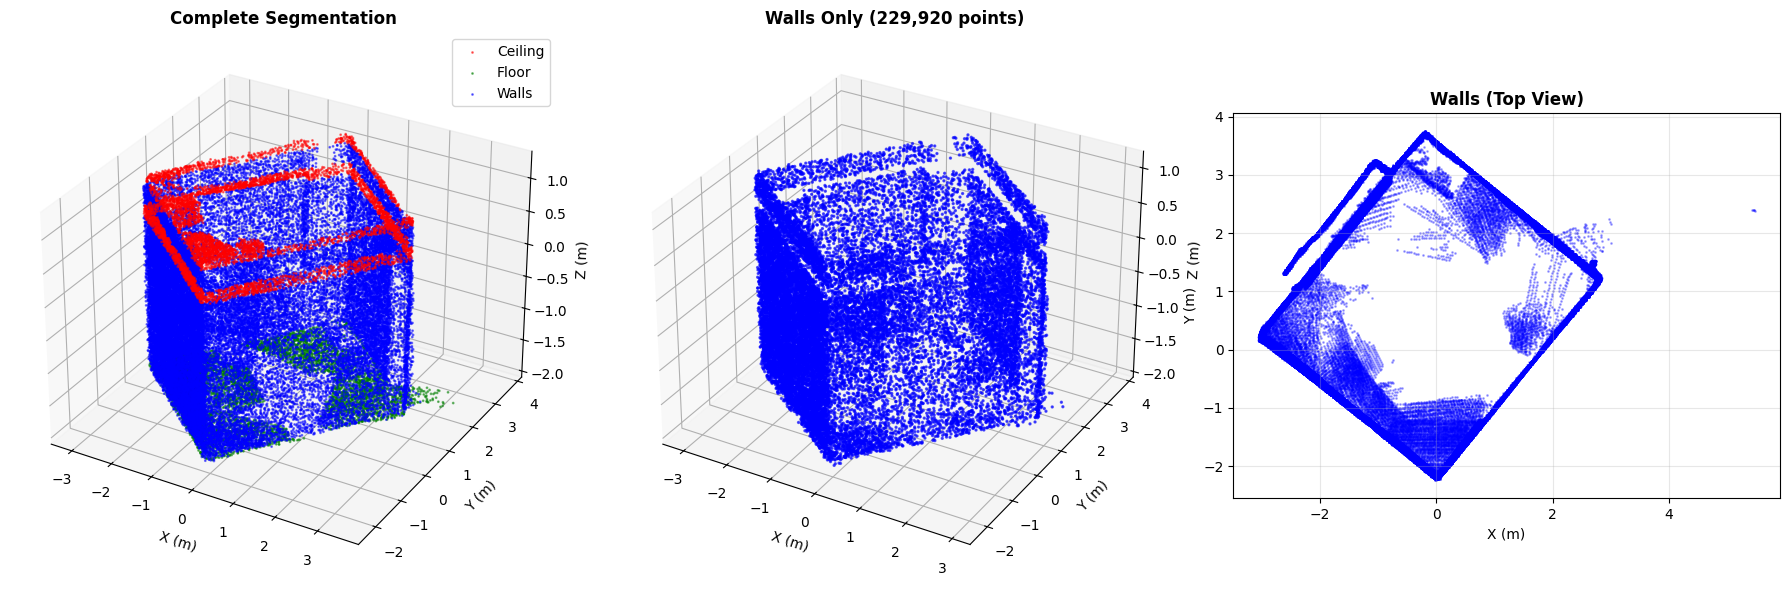

In [22]:
visualize_segmentation(points, segmentation, subsample=50000)

In [23]:
floor_height, ceiling_height = sem_seg.ransac_segmentor.get_floor_height(), sem_seg.ransac_segmentor.get_ceiling_height()

In [24]:
floor_height, ceiling_height

(np.float64(-1.8112281333333333), np.float64(1.0414431999999996))

In [26]:
ceiling_height - floor_height

np.float64(2.852671333333333)

In [25]:
wall_result = extract_walls_complete_pipeline(
    points,
    floor_height=floor_height,
    ceiling_height=ceiling_height,
    floor_margin=0.10,        # 10cm margin
    ceiling_margin=0.25,      # 10cm margin
    normal_radius=0.10,       # 10cm for normal estimation
    max_nn=30,
    vertical_threshold=0.15   # |normal_z| < 0.15 = vertical
)


COMPLETE WALL EXTRACTION PIPELINE
Input points: 298,673
Floor height: -1.811m
Ceiling height: 1.041m
Safety margins: floor=0.1m, ceiling=0.25m

──────────────────────────────────────────────────────────────────────
STEP 1: Height-based filtering
──────────────────────────────────────────────────────────────────────
Original points: 298673
Wall points: 208226 (69.7%)
  Excluded: 90,447 points (30.3%)

──────────────────────────────────────────────────────────────────────
STEP 2: Normal computation
──────────────────────────────────────────────────────────────────────
  Normal radius: 0.1m
  Max neighbors: 30
Computed normals for 208226 points

──────────────────────────────────────────────────────────────────────
STEP 3: Vertical surface filtering
──────────────────────────────────────────────────────────────────────
  Vertical threshold: |normal_z| < 0.15
Wall points: 208226
Vertical wall points: 170855 (82.1%)
  Non-vertical removed: 37,371 points (17.9%)

PIPELINE SUMMARY
Input poin

In [27]:
vertical_points = wall_result["wall_points"]
vertical_normals = wall_result["wall_normals"]

In [28]:
visualize_wall_points_3d(vertical_points, vertical_normals)

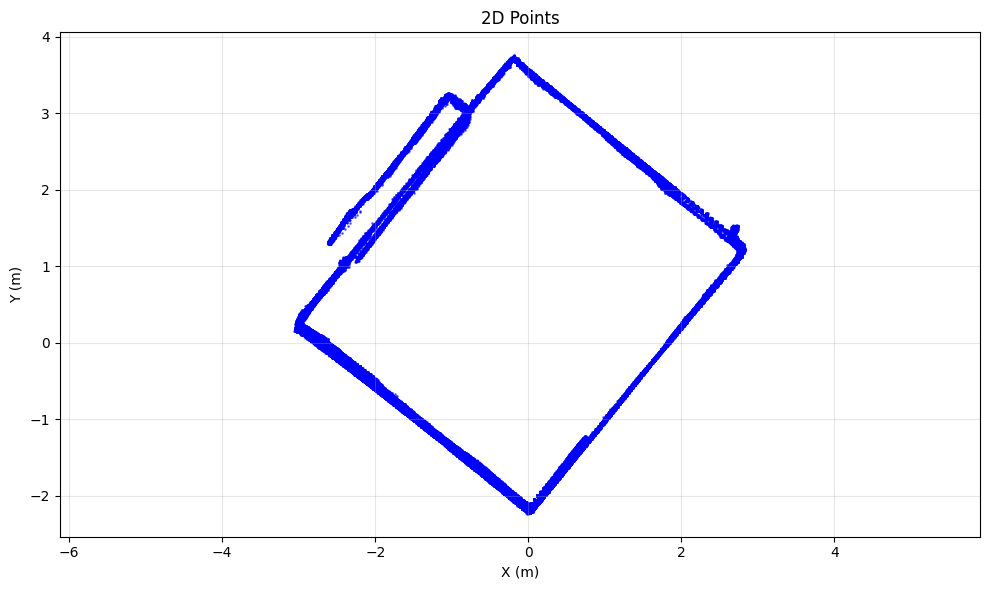

In [29]:
wall_points_2d = vertical_points[: , :2]
visualize_2d_points(wall_points_2d)

In [30]:
walls = detect_walls_ransac_clustering(
    vertical_points,
    floor_height=floor_height,
    ceiling_height=ceiling_height,
    distance_threshold=0.02,      # 3cm RANSAC
    cluster_eps=0.12,             # 12cm clustering
    min_cluster_points=50,       # At least 100 points
    min_wall_height=1.8,          # ← Increased! At least 1.8m tall
    min_wall_length=0.10,         # ← Increased! At least 80cm long
    max_wall_thickness=0.25,      # Max 25cm thick
    min_height_ratio=0.60,        # ← NEW! Must span 60% of room height
    max_iterations=30
)


WALL DETECTION: RANSAC + DBSCAN (ROBUST)
Total vertical points: 170,855
Room height: 2.85m
Min wall length: 0.1m
Min height ratio: 60%

----------------------------------------------------------------------
Iteration 1/30
Remaining: 170,855 points
  Plane: 39003 inliers, n=[0.774, -0.633, -0.003]
  Clusters: 1, largest: 39,003 pts
  Geo: L=4.50m, H=2.50m (88%), T=0.05m
  ✅ Wall 1: 39,003 pts, 4.50m × 2.50m

----------------------------------------------------------------------
Iteration 2/30
Remaining: 131,852 points
  Plane: 30226 inliers, n=[0.625, 0.780, 0.009]
  Clusters: 1, largest: 30,069 pts
  Geo: L=3.97m, H=2.50m (88%), T=0.06m
  ✅ Wall 2: 30,069 pts, 3.97m × 2.50m

----------------------------------------------------------------------
Iteration 3/30
Remaining: 101,626 points
  Plane: 26822 inliers, n=[0.620, 0.784, 0.007]


/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWa

  Clusters: 1, largest: 26,804 pts
  Geo: L=3.93m, H=2.50m (88%), T=0.05m
  ✅ Wall 3: 26,804 pts, 3.93m × 2.50m

----------------------------------------------------------------------
Iteration 4/30
Remaining: 74,804 points
  Plane: 16385 inliers, n=[0.633, 0.774, -0.009]
  Clusters: 3, largest: 15,136 pts
  Geo: L=2.79m, H=2.50m (88%), T=0.07m
  ✅ Wall 4: 15,136 pts, 2.79m × 2.50m

----------------------------------------------------------------------
Iteration 5/30
Remaining: 58,419 points
  Plane: 16755 inliers, n=[0.776, -0.631, 0.008]


/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWa

  Clusters: 1, largest: 16,730 pts
  Geo: L=4.52m, H=2.50m (88%), T=0.06m
  ✅ Wall 5: 16,730 pts, 4.52m × 2.50m

----------------------------------------------------------------------
Iteration 6/30
Remaining: 41,664 points
  Plane: 8528 inliers, n=[0.768, -0.640, 0.002]
  Clusters: 1, largest: 8,502 pts
  Geo: L=2.53m, H=1.49m (52%), T=0.04m
  ❌ Rejected

----------------------------------------------------------------------
Iteration 7/30
Remaining: 33,136 points
  Plane: 4300 inliers, n=[0.778, -0.626, 0.050]
  Clusters: 2, largest: 2,828 pts
  Geo: L=2.41m, H=0.57m (20%), T=0.06m
  ❌ Rejected

----------------------------------------------------------------------
Iteration 8/30
Remaining: 28,836 points
  Plane: 5523 inliers, n=[0.637, 0.771, -0.013]
  Clusters: 4, largest: 3,362 pts
  Geo: L=1.13m, H=2.49m (87%), T=0.06m
  ✅ Wall 6: 3,362 pts, 1.13m × 2.49m

----------------------------------------------------------------------
Iteration 9/30
Remaining: 23,313 points
  Plane: 4528 

/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWa

  Clusters: 2, largest: 1,545 pts
  Geo: L=0.77m, H=1.38m (48%), T=0.04m
  ❌ Rejected

----------------------------------------------------------------------
Iteration 13/30
Remaining: 10,380 points
  Plane: 1477 inliers, n=[0.776, -0.620, -0.112]
  Clusters: 3, largest: 611 pts
  Geo: L=1.86m, H=0.28m (10%), T=0.03m
  ❌ Rejected

----------------------------------------------------------------------
Iteration 14/30
Remaining: 8,903 points
  Plane: 1398 inliers, n=[0.806, -0.592, -0.016]
  Clusters: 1, largest: 205 pts
  Geo: L=0.20m, H=0.89m (31%), T=0.05m
  ❌ Rejected

----------------------------------------------------------------------
Iteration 15/30
Remaining: 7,505 points
  Plane: 1223 inliers, n=[0.656, 0.755, 0.015]
  Clusters: 1, largest: 198 pts
  Geo: L=0.34m, H=0.58m (20%), T=0.02m
  ❌ Rejected

----------------------------------------------------------------------
Iteration 16/30
Remaining: 6,282 points
  Plane: 1127 inliers, n=[0.638, 0.770, -0.005]
  Clusters: 1, large

In [31]:
wall_points = get_room_wall_points(walls)

In [32]:
wall_points_2d = project_points_to_2d(wall_points)

Projected 131104 points to 2D
2D bounds:
  X: [-3.051, 2.839] (range: 5.890m)
  Y: [-2.238, 3.755] (range: 5.993m)


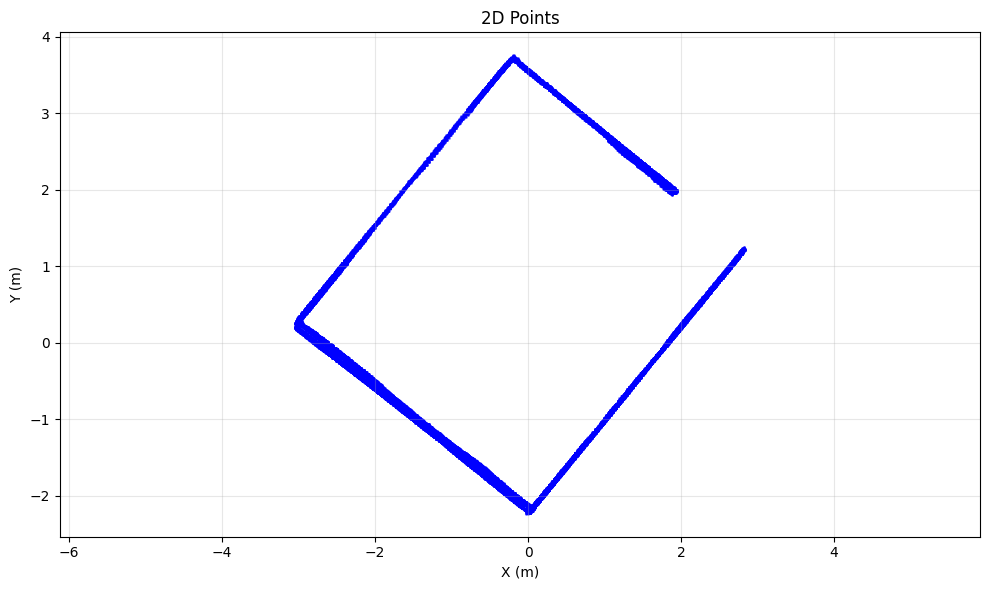

In [33]:
visualize_2d_points(wall_points_2d)

In [34]:
from get_boundary import *


CONVEX HULL DIMENSION EXTRACTION
Input points: 131,104
Hull vertices: 28
Hull perimeter: 16.919m
Hull area: 18.072m²

WALL DIMENSIONS
Wall   Length (m)   Angle (°)  Corner    
----------------------------------------------------------------------
W1     0.016        359.8      C1 → C2
W2     0.031        24.8       C2 → C3
W3     0.004        33.9       C3 → C4
W4     0.041        36.7       C4 → C5
W5     4.233        50.8       C5 → C6
W6     0.092        51.0       C6 → C7
W7     0.020        51.6       C7 → C8
W8     0.053        53.6       C8 → C9
W9     0.011        111.2      C9 → C10
W10    0.024        114.2      C10 → C11
W11    1.199        139.5      C11 → C12
W12    2.657        140.5      C12 → C13
W13    0.068        141.8      C13 → C14
W14    0.037        216.3      C14 → C15
W15    0.023        223.4      C15 → C16
W16    0.096        226.7      C16 → C17
W17    0.127        228.5      C17 → C18
W18    0.721        230.8      C18 → C19
W19    0.630        230.8      

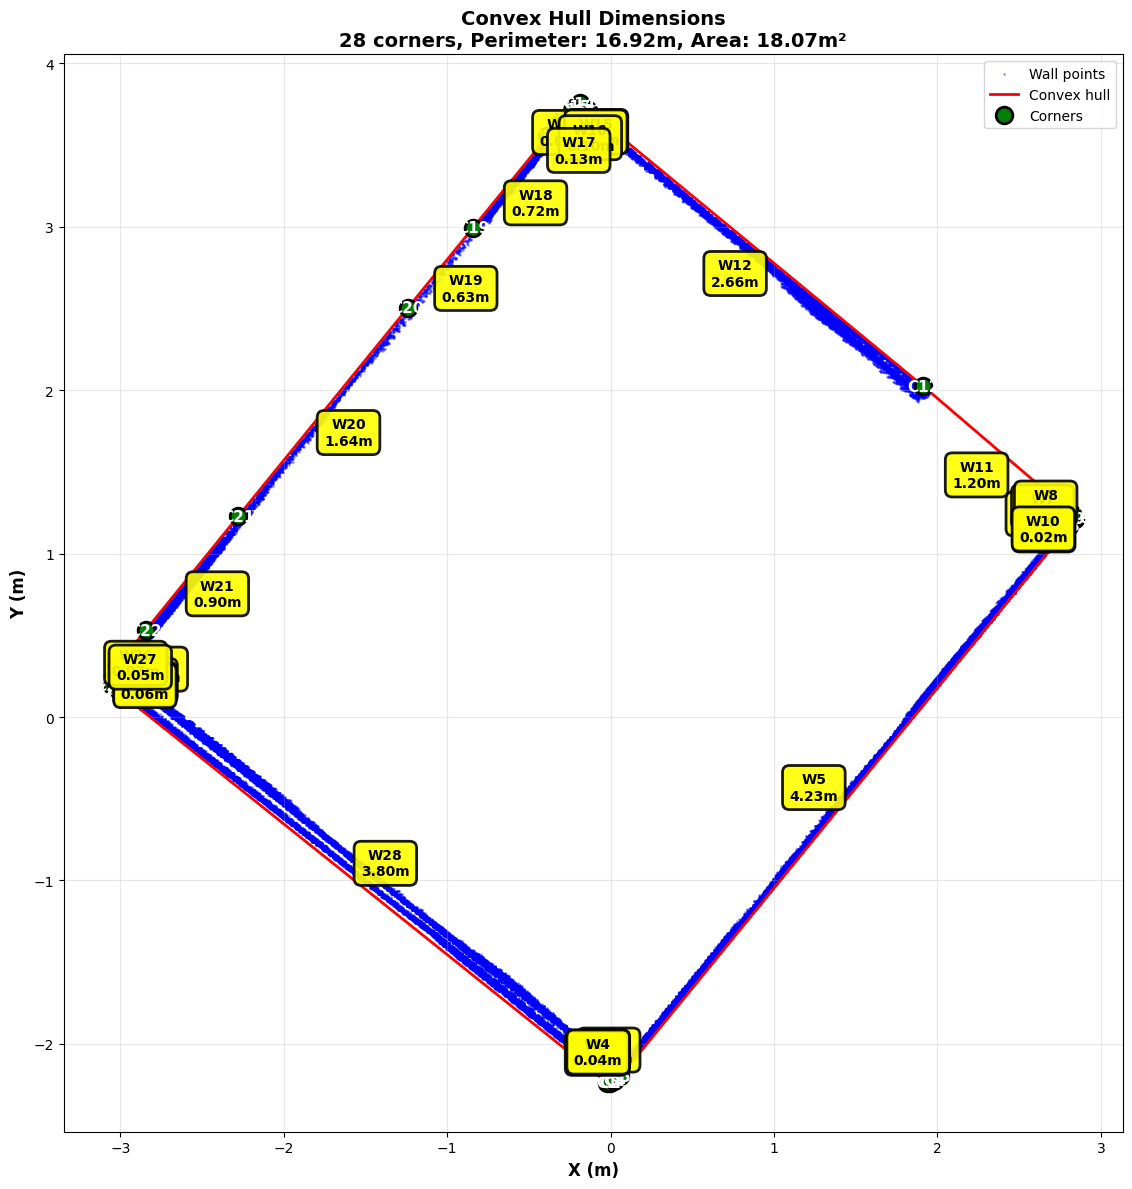

In [35]:
dimensions, hull_vertices = extract_dimensions_from_convex_hull(wall_points_2d)

visualize_convex_hull_dimensions(wall_points_2d, hull_vertices, dimensions)


CONCAVE HULL DIMENSION EXTRACTION
Input points: 131,104
Alpha (concavity): 0.3
Hull vertices: 47
Hull perimeter: 16.920m
Hull area: 18.003m²

Total walls: 47
Total perimeter: 16.920m


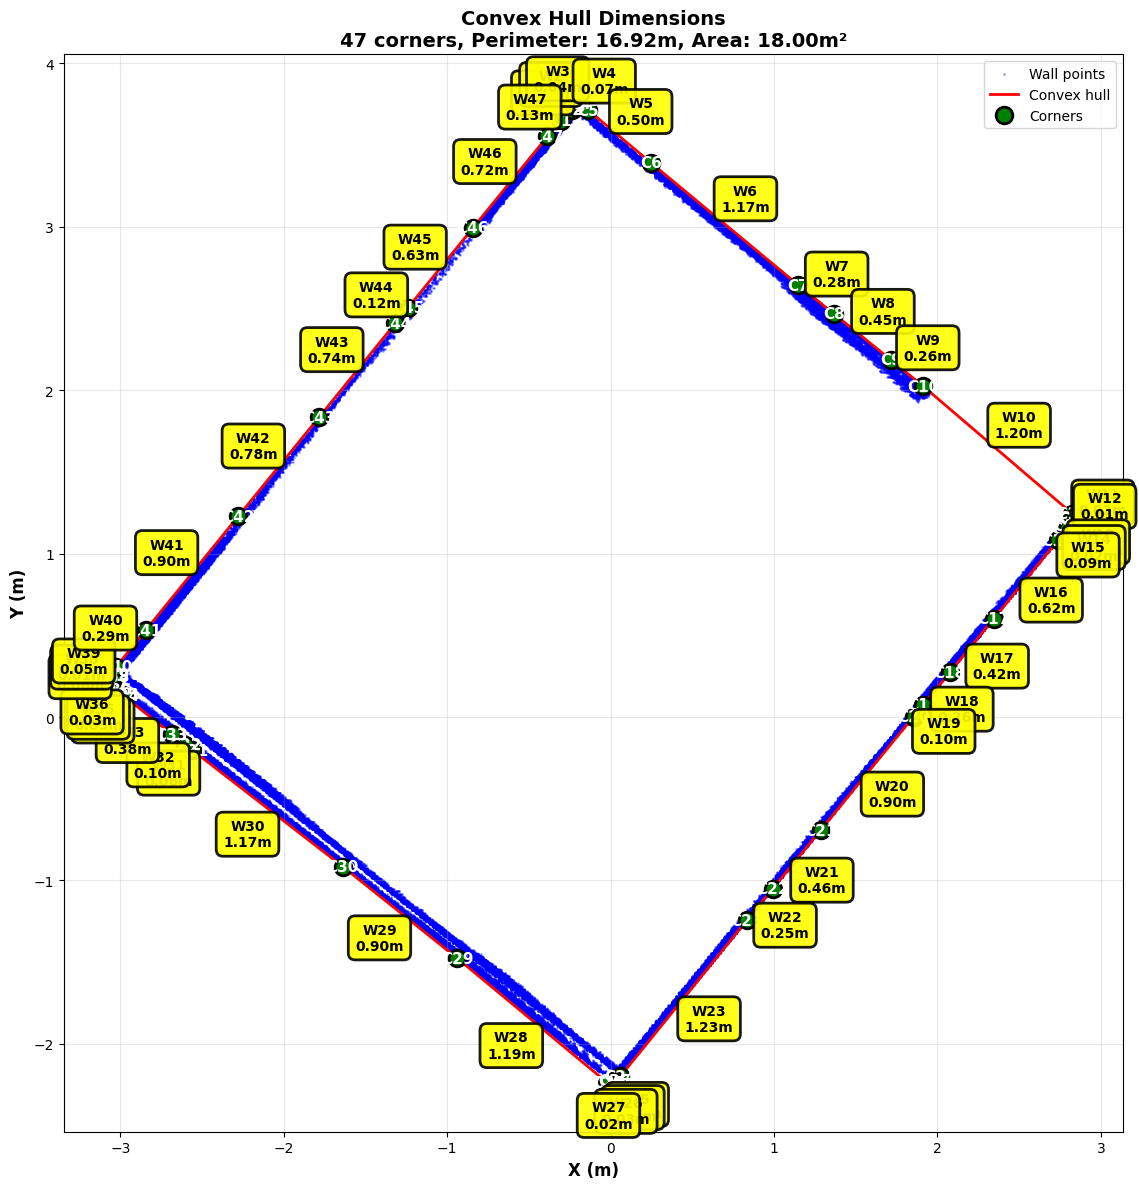

In [36]:
# Usage - CONCAVE hull (better!)
dimensions_concave, hull_concave = extract_dimensions_from_concave_hull(
    wall_points_2d,
    alpha=0.3  # Lower = more detail
)

# Visualize
visualize_convex_hull_dimensions(wall_points_2d, hull_concave, dimensions_concave)

In [37]:
# all_wall_points = np.vstack(all_wall_points)
print(f"\nTotal wall points from all walls: {len(wall_points):,}")


Total wall points from all walls: 131,104


In [38]:
wall_points_2d = wall_points[:, :2]

In [39]:
boundary_polygon = extract_room_boundary_from_walls(
    wall_points_2d,
    method='concave_hull',
    concave_ratio=0.3  # Try 0.03, 0.05, 0.10
)


BOUNDARY EXTRACTION FROM WALL POINTS
Wall points: 131,104
Method: concave_hull
Concave hull ratio: 0.3

✓ Boundary extracted:
  Vertices: 47
  Perimeter: 16.92m
  Area: 18.00m²


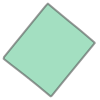

In [40]:
boundary_polygon

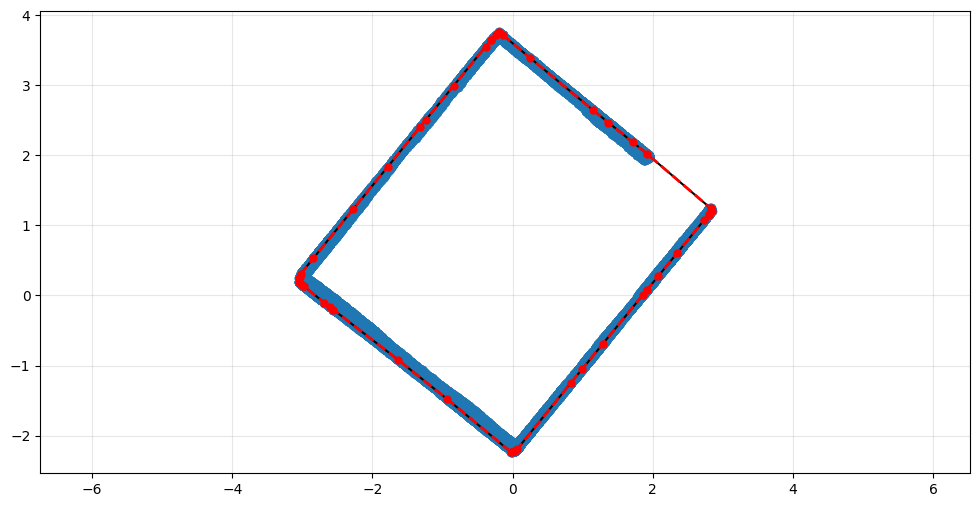

In [41]:
plt.figure(figsize=(12, 6))
plt.plot(wall_points_2d[:, 0], wall_points_2d[:, 1], 'o')

if boundary_polygon.geom_type == 'Polygon':
    # get boundary coordinates
    x, y = boundary_polygon.exterior.xy
    coords = np.array(list(zip(x, y)))
    for i in range(len(coords) - 1):
        plt.plot([coords[i, 0], coords[i+1, 0]], 
                [coords[i, 1], coords[i+1, 1]], 'k-')
    plt.plot(x, y, 'r--', lw=2, marker='o', markersize=5)

plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.show()

In [42]:
from get_simplification import *

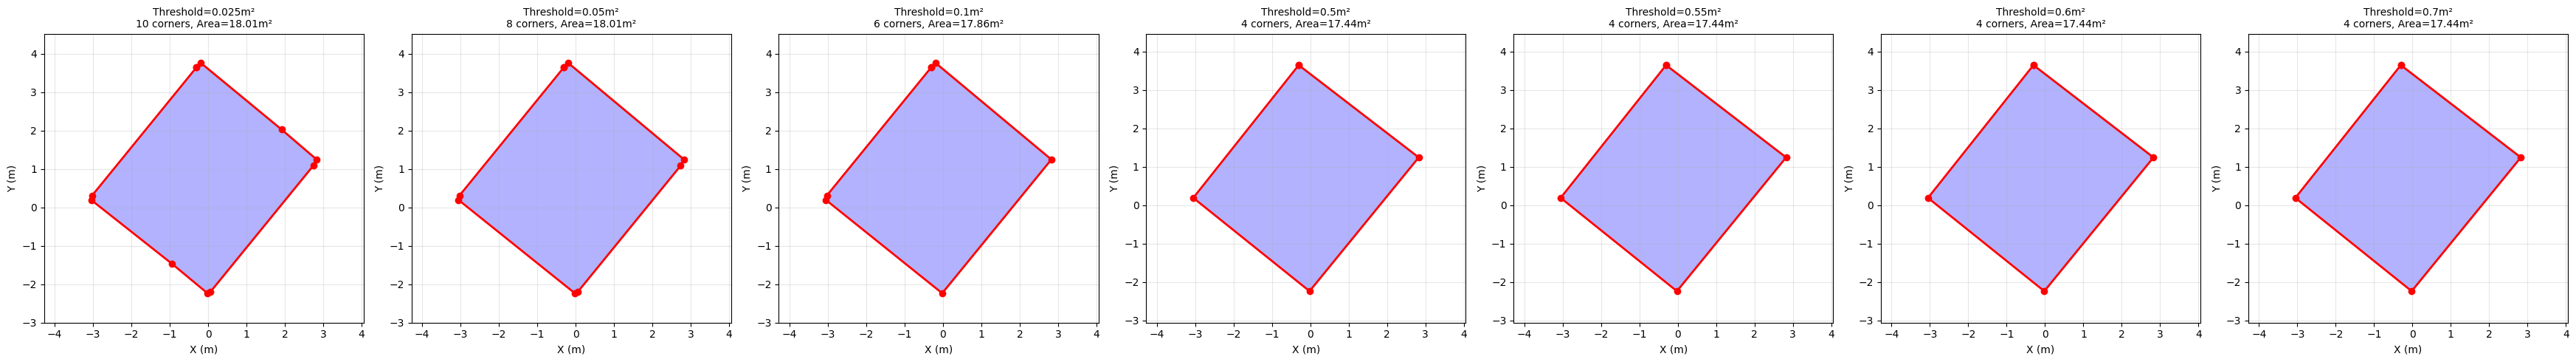


VISVALINGAM-WHYATT SIMPLIFICATION COMPARISON
Threshold (m²)  Vertices   Area (m²) 
----------------------------------------------------------------------
0.0250          10         18.01     
0.0500          8          18.01     
0.1000          6          17.86     
0.5000          4          17.44     
0.5500          4          17.44     
0.6000          4          17.44     
0.7000          4          17.44     


In [43]:
thresholds = [0.025, 0.05, 0.1, 0.5, 0.55, 0.6, 0.7]
compare_vw(boundary_polygon, thresholds)



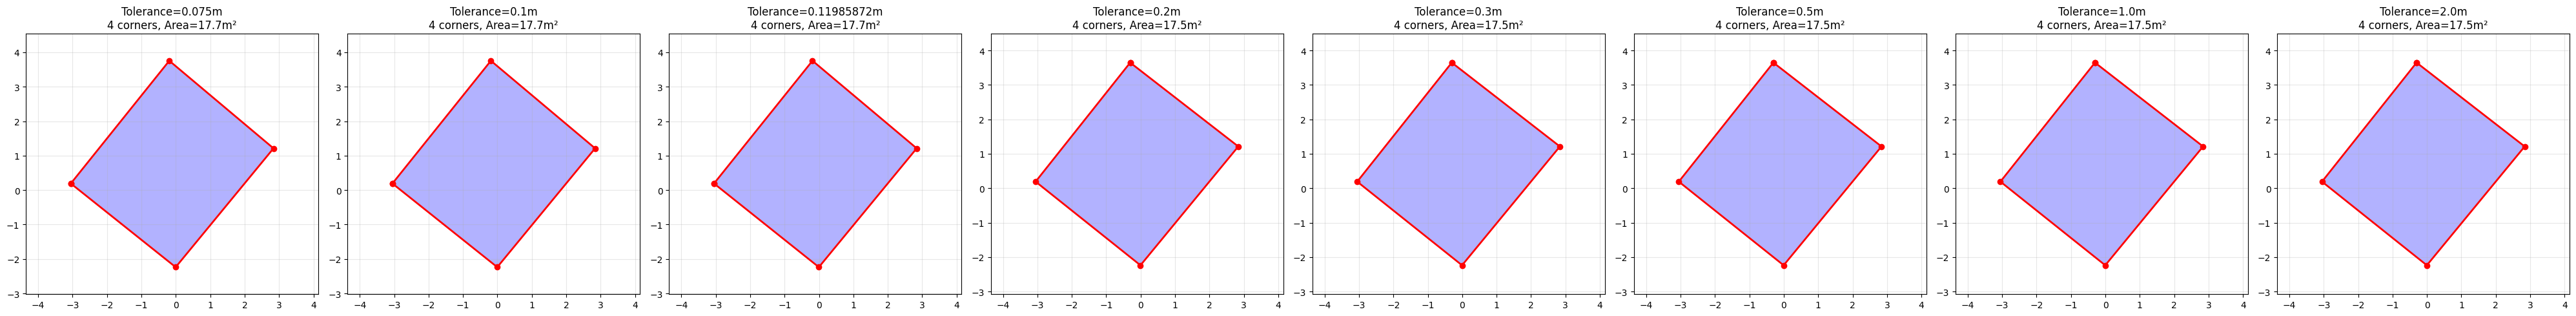

0.0750          4          17.74     
0.1000          4          17.74     
0.1199          4          17.74     
0.2000          4          17.48     
0.3000          4          17.48     
0.5000          4          17.48     
1.0000          4          17.48     
2.0000          4          17.48     


In [44]:
room_size = max(wall_points_2d[:, 0].max() - wall_points_2d[:, 0].min(),
                wall_points_2d[:, 1].max() - wall_points_2d[:, 1].min())
recommended_tolerance = room_size * 0.02  # 2% of room size
tolerances = [0.075, 0.1, recommended_tolerance, 0.2, 0.3, 0.5, 1.0, 2.0]
compare_dp(boundary_polygon, tolerances)


In [ ]:
from get_dimentions import *

In [46]:
dp_poly = boundary_polygon.simplify(0.5, preserve_topology=True)

In [47]:
dimensions = compute_polygon_dimensions(dp_poly)


POLYGON DIMENSIONS
Number of corners: 4
Wall  1: Corner 1 → Corner 2, Length:  3.975m, Angle:  322.2°
Wall  2: Corner 2 → Corner 3, Length:  4.470m, Angle:  230.5°
Wall  3: Corner 3 → Corner 4, Length:  3.897m, Angle:  141.4°
Wall  4: Corner 4 → Corner 1, Length:  4.416m, Angle:   51.5°

──────────────────────────────────────────────────────────────────────
Total perimeter: 16.758m
Total area:      17.484m²


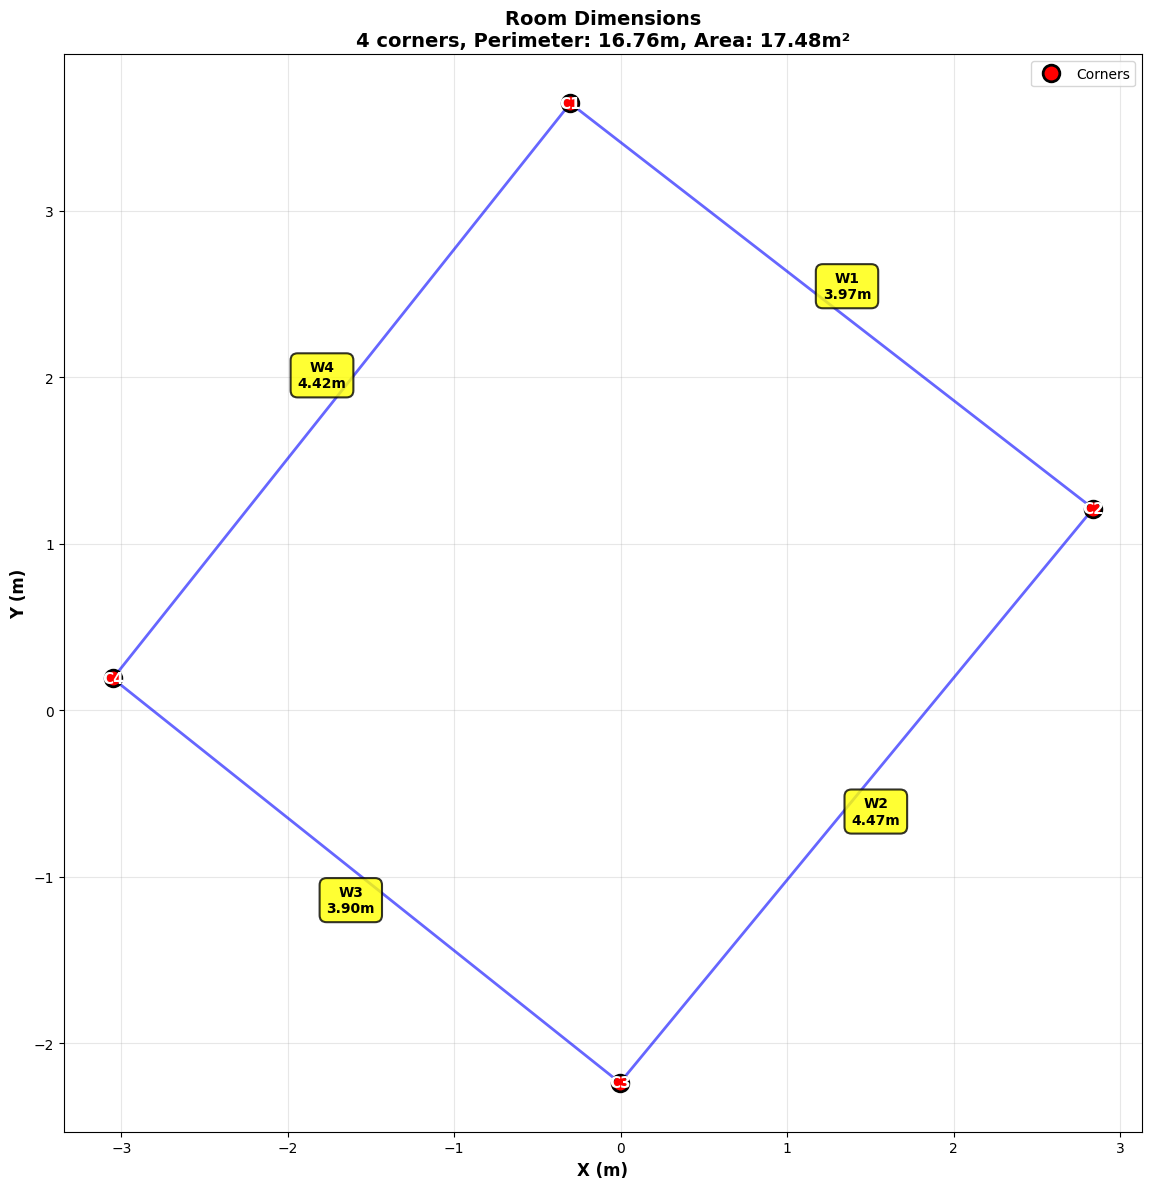

In [48]:
visualize_polygon_dimensions(dp_poly, dimensions)

In [52]:
np.array(boundary_polygon.exterior.coords)

array([[-3.02640000e-01,  3.64685000e+00],
       [-2.36561000e-01,  3.71690200e+00],
       [-2.19613000e-01,  3.73290900e+00],
       [-1.89448000e-01,  3.75509500e+00],
       [-1.35823000e-01,  3.71287800e+00],
       [ 2.47119000e-01,  3.39087300e+00],
       [ 1.14795700e+00,  2.64331500e+00],
       [ 1.36699400e+00,  2.46619000e+00],
       [ 1.71461200e+00,  2.18599200e+00],
       [ 1.91407950e+00,  2.02290550e+00],
       [ 2.82533400e+00,  1.24381900e+00],
       [ 2.83512350e+00,  1.22208350e+00],
       [ 2.83907300e+00,  1.21188000e+00],
       [ 2.80748350e+00,  1.16899850e+00],
       [ 2.79481600e+00,  1.15301600e+00],
       [ 2.73706900e+00,  1.08174300e+00],
       [ 2.34512100e+00,  6.02474000e-01],
       [ 2.07593467e+00,  2.73736000e-01],
       [ 1.91388200e+00,  7.58395000e-02],
       [ 1.85351000e+00,  2.15300000e-03],
       [ 1.28532000e+00, -6.92166500e-01],
       [ 9.91900000e-01, -1.05084000e+00],
       [ 8.34011500e-01, -1.24334650e+00],
       [ 6.

In [53]:
simplified_points = simplify_coords_vw(np.array(boundary_polygon.exterior.coords), epsilon=0.04)

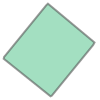

In [55]:
Polygon(simplified_points)

In [56]:
dimensions = compute_polygon_dimensions(Polygon(simplified_points))


POLYGON DIMENSIONS
Number of corners: 8
Wall  1: Corner 1 → Corner 2, Length:  0.157m, Angle:   43.7°
Wall  2: Corner 2 → Corner 3, Length:  3.924m, Angle:  320.2°
Wall  3: Corner 3 → Corner 4, Length:  0.185m, Angle:  241.4°
Wall  4: Corner 4 → Corner 5, Length:  4.233m, Angle:  230.8°
Wall  5: Corner 5 → Corner 6, Length:  0.089m, Angle:  206.5°
Wall  6: Corner 6 → Corner 7, Length:  3.884m, Angle:  141.3°
Wall  7: Corner 7 → Corner 8, Length:  0.119m, Angle:   77.4°
Wall  8: Corner 8 → Corner 1, Length:  4.309m, Angle:   50.8°

──────────────────────────────────────────────────────────────────────
Total perimeter: 16.900m
Total area:      18.014m²


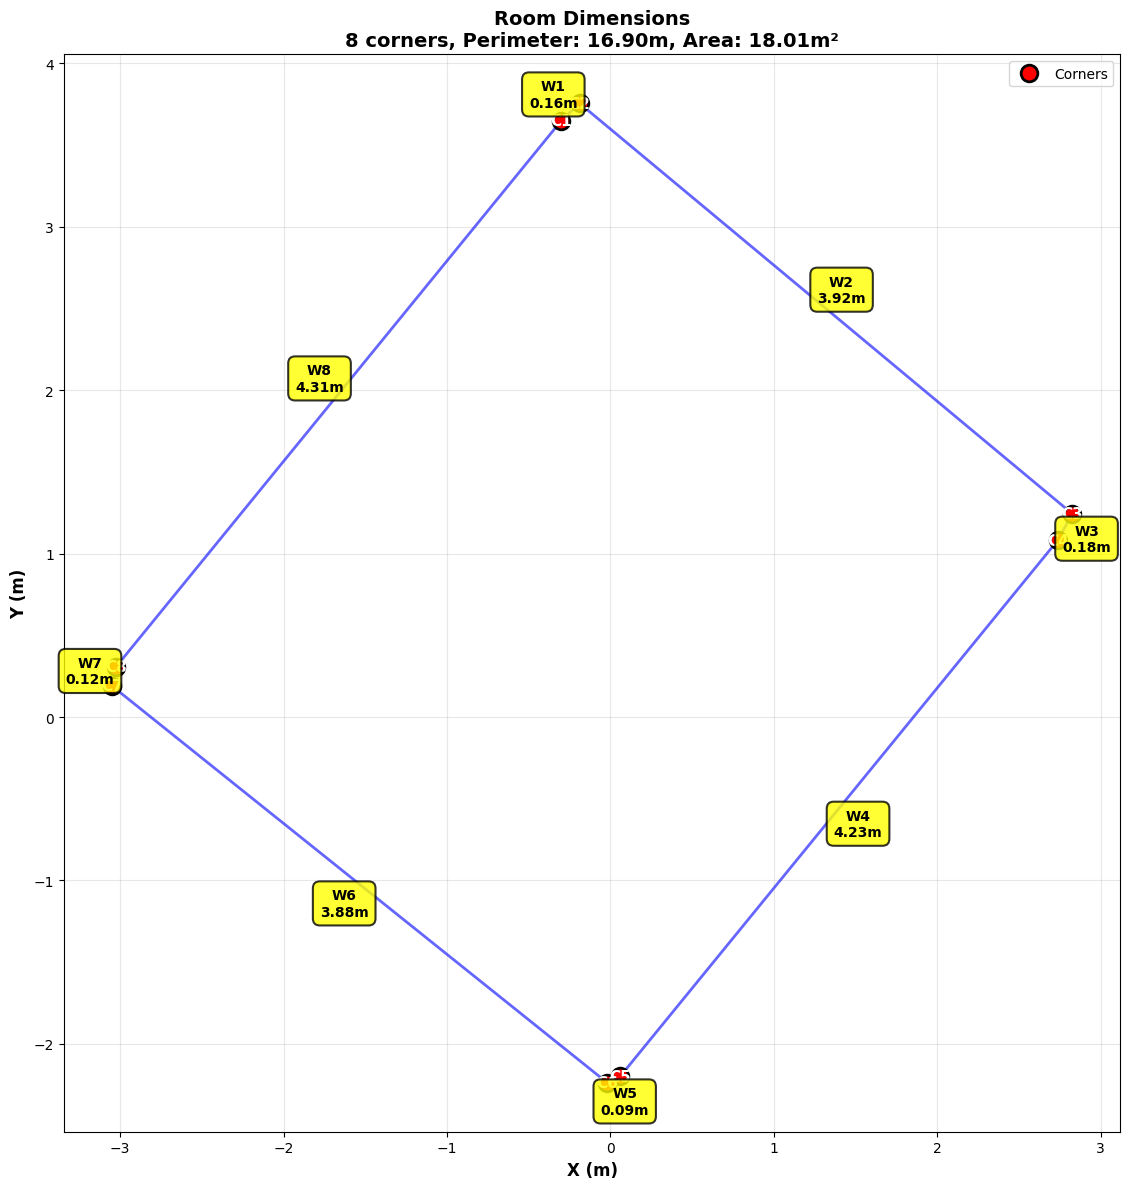

In [57]:
visualize_polygon_dimensions(Polygon(simplified_points), dimensions)

In [58]:
median_thickness = compute_median_wall_thickness(walls)


WALL THICKNESS ANALYSIS
Walls analyzed: 6
Median thickness: 0.061m (6.1cm)
Mean thickness: 0.060m (6.0cm)
Range: 0.048m - 0.074m


In [59]:
poly = Polygon(simplified_points)

In [60]:
offset_implicit = offset_boundary_inward(
    boundary_polygon,
    offset_distance=median_thickness / 2  # Half thickness = centerline
)


BOUNDARY OFFSET (EXPLICIT → IMPLICIT)
Offset distance: 0.030m (3.0cm)

Original area: 18.00m²
Offset area:   17.49m²
Reduction:     0.51m² (2.8%)


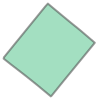

In [61]:
offset_implicit

In [164]:
polygon_implicit = np.array(offset_implicit.exterior.coords)[:-1]

In [179]:
simplified_points = simplify_coords_vw(polygon_implicit, epsilon=0.001)

In [180]:
dimensions = compute_polygon_dimensions(simplified_points)


POLYGON DIMENSIONS
Number of corners: 62
Wall  1: Corner 1 → Corner 2, Length:  0.097m, Angle:  108.0°
Wall  2: Corner 2 → Corner 3, Length:  0.105m, Angle:  125.4°
Wall  3: Corner 3 → Corner 4, Length:  0.231m, Angle:  138.7°
Wall  4: Corner 4 → Corner 5, Length:  0.156m, Angle:   49.8°
Wall  5: Corner 5 → Corner 6, Length:  0.398m, Angle:   46.7°
Wall  6: Corner 6 → Corner 7, Length:  0.240m, Angle:   48.9°
Wall  7: Corner 7 → Corner 8, Length:  0.286m, Angle:   46.5°
Wall  8: Corner 8 → Corner 9, Length:  0.447m, Angle:   48.4°
Wall  9: Corner 9 → Corner 10, Length:  0.346m, Angle:   47.4°
Wall 10: Corner 10 → Corner 11, Length:  0.582m, Angle:   46.7°
Wall 11: Corner 11 → Corner 12, Length:  0.146m, Angle:   50.3°
Wall 12: Corner 12 → Corner 13, Length:  0.384m, Angle:   46.0°
Wall 13: Corner 13 → Corner 14, Length:  0.182m, Angle:   51.2°
Wall 14: Corner 14 → Corner 15, Length:  0.202m, Angle:   42.9°
Wall 15: Corner 15 → Corner 16, Length:  0.260m, Angle:   48.0°
Wall 16: Corner

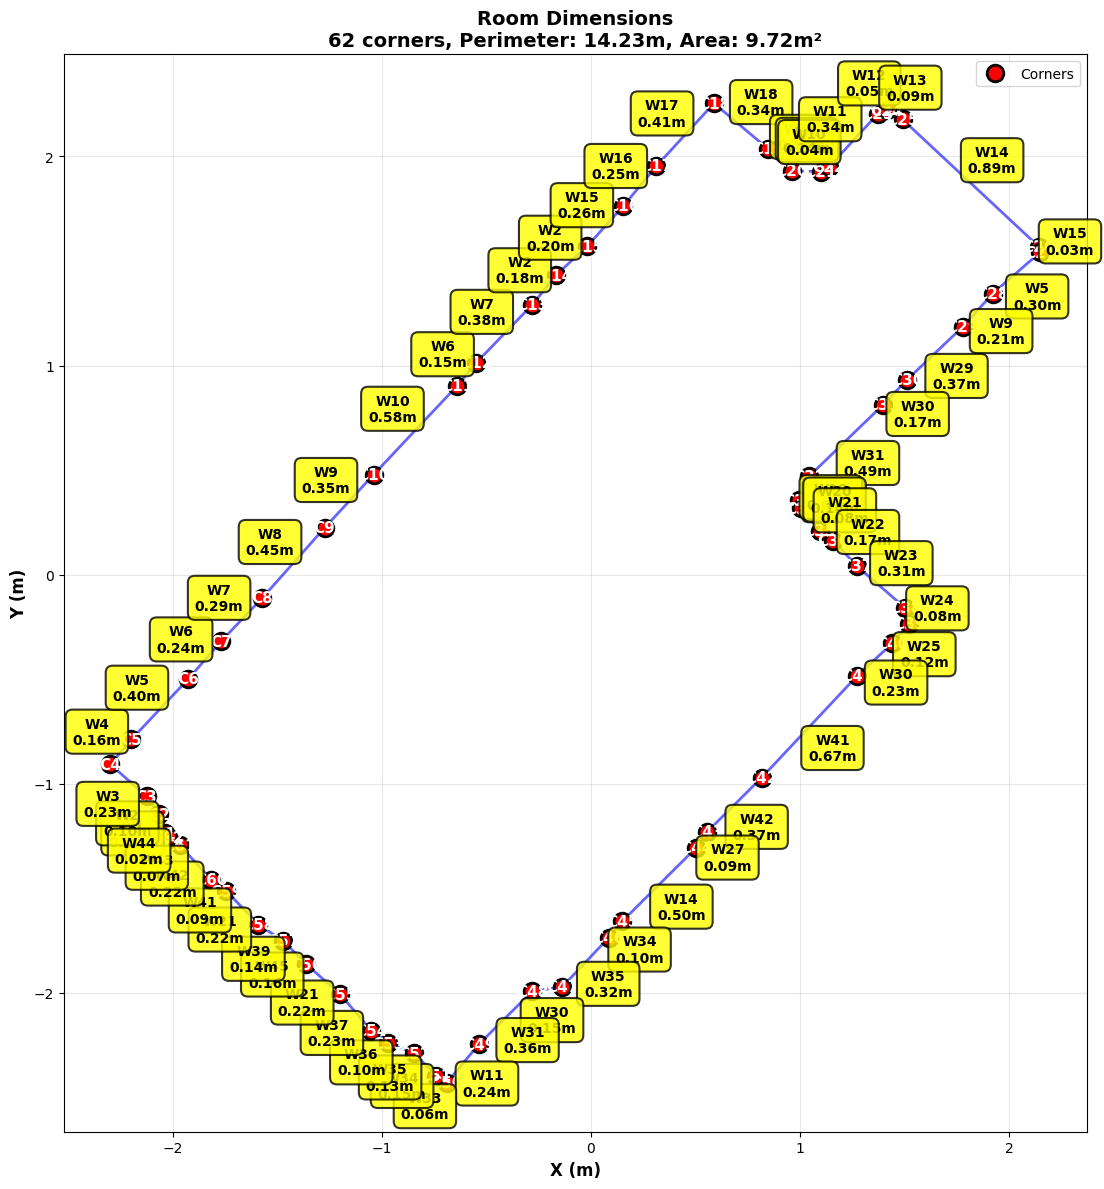

In [233]:
visualize_polygon_dimensions(simplified_points, dimensions)

In [234]:
def merge_nearby_vertices_simple(polygon_points, distance_threshold=0.10):
    """
    Merge consecutive vertices that are very close together
    
    This preserves perimeter accuracy while reducing vertex count!
    
    Parameters:
    -----------
    polygon_points : np.ndarray (N, 2)
        Polygon vertices in order
    distance_threshold : float
        Merge vertices closer than this (meters)
    
    Returns:
    --------
    merged_points : np.ndarray (M, 2)
        Simplified polygon (M ≤ N)
    """
    
    print(f"\n{'='*70}")
    print(f"SIMPLE VERTEX MERGING")
    print(f"{'='*70}")
    print(f"Input vertices: {len(polygon_points)}")
    print(f"Distance threshold: {distance_threshold}m")
    
    if len(polygon_points) < 3:
        return polygon_points
    
    merged = [polygon_points[0]]
    
    for i in range(1, len(polygon_points)):
        current = polygon_points[i]
        previous = merged[-1]
        
        distance = np.linalg.norm(current - previous)
        
        if distance >= distance_threshold:
            # Far enough, keep this vertex
            merged.append(current)
        else:
            # Too close, skip (merge with previous)
            print(f"  Merging vertex {i} with previous (distance: {distance:.3f}m)")
    
    # Check wrap-around (last to first)
    if len(merged) > 1:
        distance_to_start = np.linalg.norm(merged[-1] - merged[0])
        if distance_to_start < distance_threshold:
            print(f"  Merging last vertex with first (distance: {distance_to_start:.3f}m)")
            merged = merged[:-1]
    
    merged_points = np.array(merged)
    
    print(f"\n✓ Result: {len(polygon_points)} → {len(merged_points)} vertices")
    
    # Check perimeter preservation
    from shapely.geometry import Polygon
    original_perim = Polygon(polygon_points).length
    merged_perim = Polygon(merged_points).length
    
    print(f"\nPerimeter check:")
    print(f"  Original: {original_perim:.3f}m")
    print(f"  Merged:   {merged_perim:.3f}m")
    print(f"  Diff:     {abs(original_perim - merged_perim):.3f}m "
          f"({100*abs(original_perim - merged_perim)/original_perim:.2f}%)")
    
    return merged_points

In [236]:
merged_points = merge_nearby_vertices_simple(simplified_points)


SIMPLE VERTEX MERGING
Input vertices: 62
Distance threshold: 0.1m
  Merging vertex 1 with previous (distance: 0.097m)
  Merging vertex 21 with previous (distance: 0.044m)
  Merging vertex 23 with previous (distance: 0.046m)
  Merging vertex 26 with previous (distance: 0.026m)
  Merging vertex 33 with previous (distance: 0.041m)
  Merging vertex 35 with previous (distance: 0.081m)
  Merging vertex 38 with previous (distance: 0.080m)
  Merging vertex 43 with previous (distance: 0.093m)
  Merging vertex 50 with previous (distance: 0.062m)
  Merging vertex 53 with previous (distance: 0.099m)
  Merging vertex 59 with previous (distance: 0.092m)
  Merging vertex 61 with previous (distance: 0.068m)
  Merging last vertex with first (distance: 0.088m)

✓ Result: 62 → 49 vertices

Perimeter check:
  Original: 14.229m
  Merged:   14.163m
  Diff:     0.065m (0.46%)


In [182]:
def merge_collinear_walls(dimensions, 
                         angle_tolerance=5.0,
                         max_gap=0.10):
    """
    Merge walls that are collinear (on same line)
    
    Strategy:
    1. Find pairs of consecutive walls with similar angles
    2. Check if they're collinear (approximately on same line)
    3. Merge them into single wall
    4. Repeat until no more merges possible
    
    Parameters:
    -----------
    dimensions : list of dict
        Wall dimensions from compute_polygon_dimensions()
    angle_tolerance : float
        Max angle difference to consider collinear (degrees)
    max_gap : float
        Maximum gap between walls to merge (meters)
    
    Returns:
    --------
    merged_dimensions : list of dict
        Merged wall dimensions
    """
    
    print(f"\n{'='*70}")
    print(f"MERGING COLLINEAR WALLS")
    print(f"{'='*70}")
    print(f"Input walls: {len(dimensions)}")
    print(f"Angle tolerance: {angle_tolerance}°")
    print(f"Max gap: {max_gap}m")
    
    merged = []
    skip_indices = set()
    
    i = 0
    while i < len(dimensions):
        if i in skip_indices:
            i += 1
            continue
        
        # Start new merged segment
        current = dimensions[i]
        merge_chain = [i]
        
        # Try to extend forward
        j = i + 1
        while j < len(dimensions):
            if j in skip_indices:
                j += 1
                continue
            
            next_wall = dimensions[j]
            
            # Check angle similarity
            angle_diff = abs(current['angle'] - next_wall['angle'])
            # Handle wrap-around (e.g., 359° and 1°)
            angle_diff = min(angle_diff, 360 - angle_diff)
            
            if angle_diff <= angle_tolerance:
                # Check gap
                gap = np.linalg.norm(current['end_point'] - next_wall['start_point'])
                
                if gap <= max_gap:
                    # Merge!
                    merge_chain.append(j)
                    current = next_wall  # Continue from this wall
                    j += 1
                else:
                    # Gap too large
                    break
            else:
                # Angle too different
                break
        
        # Create merged wall from chain
        if len(merge_chain) == 1:
            # No merge, keep original
            merged.append(dimensions[i])
        else:
            # Merge multiple walls
            first_wall = dimensions[merge_chain[0]]
            last_wall = dimensions[merge_chain[-1]]
            
            # New wall from first start to last end
            merged_start = first_wall['start_point']
            merged_end = last_wall['end_point']
            merged_vec = merged_end - merged_start
            merged_length = np.linalg.norm(merged_vec)
            merged_angle = np.degrees(np.arctan2(merged_vec[1], merged_vec[0])) % 360
            
            # Sum of individual lengths (for comparison)
            total_length = sum(dimensions[idx]['length'] for idx in merge_chain)
            
            merged_wall = {
                'wall_id': len(merged) + 1,
                'start_point': merged_start,
                'end_point': merged_end,
                'length': merged_length,
                'angle': merged_angle,
                'merged_from': merge_chain,
                'num_segments': len(merge_chain)
            }
            
            merged.append(merged_wall)
            
            print(f"  Merged {len(merge_chain)} walls (indices {merge_chain[0]}-{merge_chain[-1]}): "
                  f"{total_length:.2f}m → {merged_length:.2f}m")
            
            # Mark as processed
            skip_indices.update(merge_chain)
        
        i += 1
    
    print(f"\n✓ Result: {len(dimensions)} → {len(merged)} walls")
    
    # Renumber
    for idx, wall in enumerate(merged, 1):
        wall['wall_id'] = idx
    
    return merged


def merge_short_walls(dimensions, min_wall_length=0.30):
    """
    Merge very short walls with their neighbors
    
    Strategy:
    - Find walls shorter than threshold
    - Merge with neighbor (prefer same angle)
    - Repeat
    
    Parameters:
    -----------
    dimensions : list of dict
        Wall dimensions
    min_wall_length : float
        Walls shorter than this get merged (meters)
    
    Returns:
    --------
    merged : list of dict
        Dimensions with short walls merged
    """
    
    print(f"\n{'='*70}")
    print(f"MERGING SHORT WALLS")
    print(f"{'='*70}")
    print(f"Input walls: {len(dimensions)}")
    print(f"Min wall length: {min_wall_length}m")
    
    # Convert to list for easier manipulation
    walls = list(dimensions)
    
    iterations = 0
    max_iterations = 50
    
    while iterations < max_iterations:
        iterations += 1
        
        # Find shortest wall
        shortest_idx = None
        shortest_length = float('inf')
        
        for i, wall in enumerate(walls):
            if wall['length'] < min_wall_length and wall['length'] < shortest_length:
                shortest_idx = i
                shortest_length = wall['length']
        
        if shortest_idx is None:
            # No more short walls
            break
        
        # Merge with neighbor
        n = len(walls)
        prev_idx = (shortest_idx - 1) % n
        next_idx = (shortest_idx + 1) % n
        
        short_wall = walls[shortest_idx]
        prev_wall = walls[prev_idx]
        next_wall = walls[next_idx]
        
        # Decide which neighbor to merge with (prefer similar angle)
        angle_diff_prev = abs(short_wall['angle'] - prev_wall['angle'])
        angle_diff_prev = min(angle_diff_prev, 360 - angle_diff_prev)
        
        angle_diff_next = abs(short_wall['angle'] - next_wall['angle'])
        angle_diff_next = min(angle_diff_next, 360 - angle_diff_next)
        
        if angle_diff_prev < angle_diff_next:
            # Merge with previous
            merge_with = prev_idx
            keep_idx = prev_idx
            remove_idx = shortest_idx
        else:
            # Merge with next
            merge_with = shortest_idx
            keep_idx = shortest_idx
            remove_idx = next_idx
        
        # Create merged wall
        if merge_with == prev_idx:
            merged_start = prev_wall['start_point']
            merged_end = short_wall['end_point']
        else:
            merged_start = short_wall['start_point']
            merged_end = next_wall['end_point']
        
        merged_vec = merged_end - merged_start
        merged_length = np.linalg.norm(merged_vec)
        merged_angle = np.degrees(np.arctan2(merged_vec[1], merged_vec[0])) % 360
        
        walls[keep_idx] = {
            'wall_id': keep_idx + 1,
            'start_point': merged_start,
            'end_point': merged_end,
            'length': merged_length,
            'angle': merged_angle
        }
        
        # Remove the other wall
        walls.pop(remove_idx)
        
        print(f"  Iteration {iterations}: Merged wall {remove_idx+1} ({shortest_length:.2f}m) → "
              f"New length: {merged_length:.2f}m")
    
    print(f"\n✓ Result: {len(dimensions)} → {len(walls)} walls")
    
    # Renumber
    for idx, wall in enumerate(walls, 1):
        wall['wall_id'] = idx
    
    return walls


def merge_walls_complete(dimensions, 
                        angle_tolerance=8.0,
                        max_gap=0.15,
                        min_wall_length=0.50):
    """
    Complete wall merging pipeline
    
    Step 1: Merge collinear walls
    Step 2: Merge short walls with neighbors
    Step 3: Repeat until stable
    """
    
    print(f"\n{'='*70}")
    print(f"COMPLETE WALL MERGING PIPELINE")
    print(f"{'='*70}")
    print(f"Initial walls: {len(dimensions)}")
    
    current = dimensions
    prev_count = len(current)
    
    for iteration in range(5):  # Max 5 rounds
        print(f"\n{'-'*70}")
        print(f"ROUND {iteration + 1}")
        print(f"{'-'*70}")
        
        # Step 1: Merge collinear
        current = merge_collinear_walls(
            current,
            angle_tolerance=angle_tolerance,
            max_gap=max_gap
        )
        
        # Step 2: Merge short
        current = merge_short_walls(
            current,
            min_wall_length=min_wall_length
        )
        
        # Check if stable
        new_count = len(current)
        if new_count == prev_count:
            print(f"\n✓ Converged after {iteration + 1} rounds")
            break
        
        prev_count = new_count
    
    print(f"\n{'='*70}")
    print(f"MERGING COMPLETE")
    print(f"{'='*70}")
    print(f"Final walls: {len(current)}")
    print(f"Reduction: {len(dimensions)} → {len(current)} "
          f"({100*(len(dimensions)-len(current))/len(dimensions):.1f}%)")
    
    return current

In [230]:
merged_dimensions = merge_walls_complete(
    dimensions,
    angle_tolerance=5.0,      # Walls within 8° are considered same direction
    max_gap=0.05,             # Walls < 15cm apart can merge
    min_wall_length=0.15     # Walls < 50cm get merged with neighbors
)


COMPLETE WALL MERGING PIPELINE
Initial walls: 62

----------------------------------------------------------------------
ROUND 1
----------------------------------------------------------------------

MERGING COLLINEAR WALLS
Input walls: 62
Angle tolerance: 5.0°
Max gap: 0.05m
  Merged 9 walls (indices 3-11): 2.98m → 2.98m
  Merged 3 walls (indices 14-16): 0.92m → 0.91m
  Merged 2 walls (indices 17-18): 0.49m → 0.49m
  Merged 4 walls (indices 27-30): 1.24m → 1.24m
  Merged 3 walls (indices 39-41): 1.26m → 1.26m
  Merged 2 walls (indices 44-45): 0.43m → 0.43m
  Merged 2 walls (indices 54-55): 0.37m → 0.37m

✓ Result: 62 → 44 walls

MERGING SHORT WALLS
Input walls: 44
Min wall length: 0.15m
  Iteration 1: Merged wall 1 (0.02m) → New length: 0.12m
  Iteration 2: Merged wall 14 (0.03m) → New length: 0.91m
  Iteration 3: Merged wall 18 (0.04m) → New length: 0.18m
  Iteration 4: Merged wall 10 (0.04m) → New length: 0.39m
  Iteration 5: Merged wall 10 (0.05m) → New length: 0.43m
  Iteration 

In [231]:
merged_dimensions

[{'wall_id': 1,
  'start_point': array([-2.29901884, -0.90718542]),
  'end_point': array([0.58805826, 2.25433838]),
  'length': np.float64(4.281407118864741),
  'angle': np.float64(47.59793304368246),
  'merged_from': [0, 1],
  'num_segments': 2},
 {'wall_id': 2,
  'start_point': array([0.58805826, 2.25433838]),
  'end_point': array([1.09962397, 1.92793001]),
  'length': np.float64(0.6068293864909806),
  'angle': np.float64(327.45978079742537)},
 {'wall_id': 3,
  'start_point': array([1.09962397, 1.92793001]),
  'end_point': array([1.41336144, 2.22209307]),
  'length': np.float64(0.43007336494544585),
  'angle': np.float64(43.155711770554134)},
 {'wall_id': 4,
  'start_point': array([1.41336144, 2.22209307]),
  'end_point': array([2.14904598, 1.54287783]),
  'length': np.float64(1.0012817220202614),
  'angle': np.float64(317.2854879255132)},
 {'wall_id': 5,
  'corner_start': 27,
  'corner_end': 28,
  'start_point': array([2.14904598, 1.54287783]),
  'end_point': array([1.92134143, 1.34

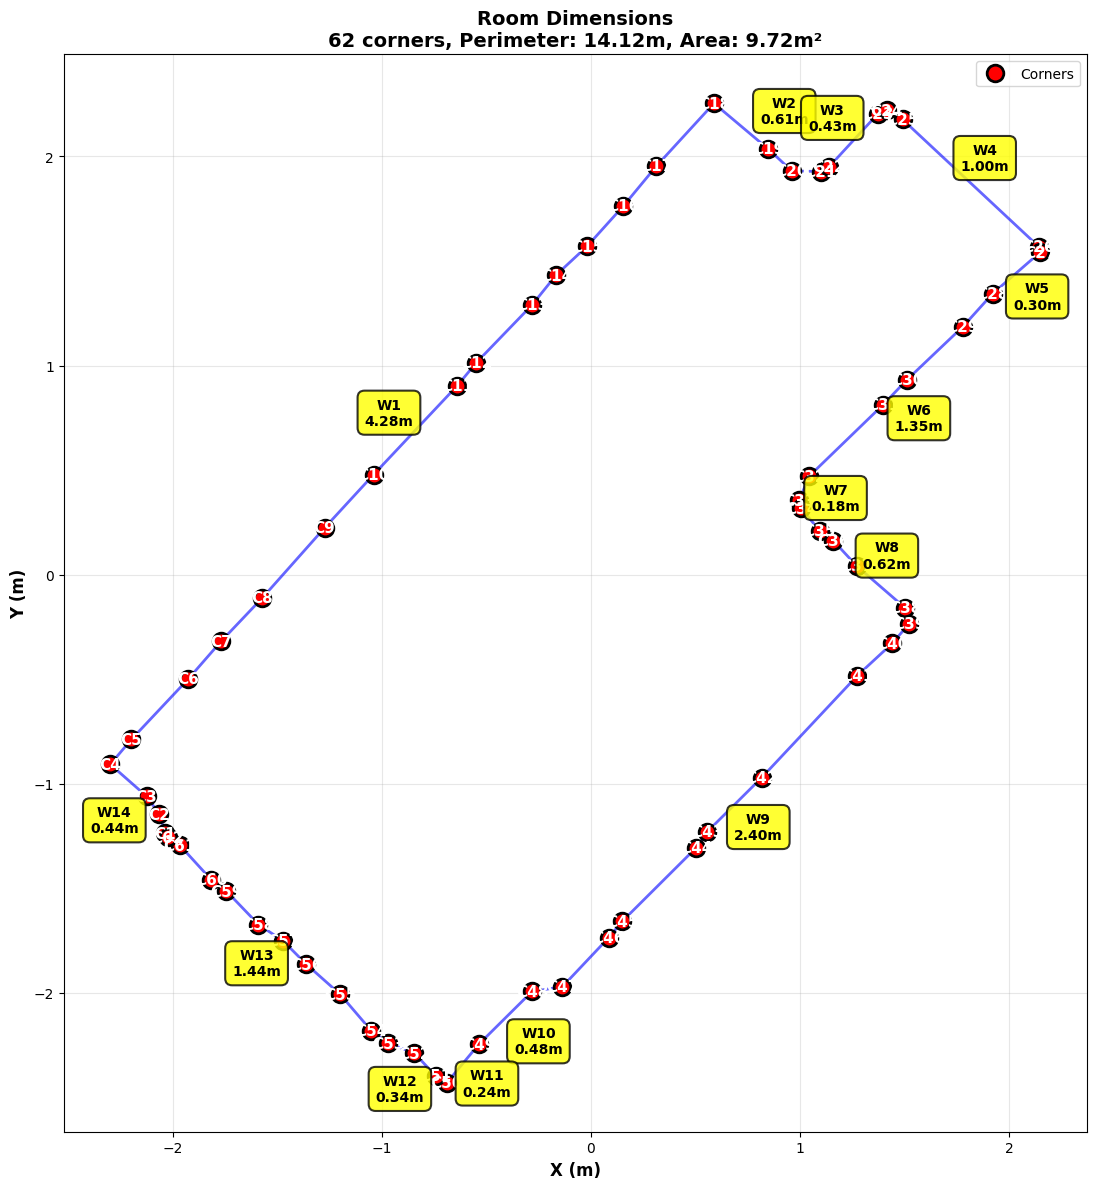

In [232]:
visualize_polygon_dimensions(simplified_points, merged_dimensions)

In [196]:
def extract_accurate_floorplan(wall_points, 
                               concave_ratio=0.05,
                               offset_distance=None,
                               merge_angle_tol=8.0,
                               merge_gap=0.15,
                               min_wall_length=0.30):
    """
    Optimized pipeline for accurate floorplan extraction
    NO simplification - just merging
    """
    
    # Step 1: Concave hull
    from shapely.geometry import MultiPoint
    import shapely
    
    multi_point = MultiPoint(wall_points[:, :2])
    boundary = shapely.concave_hull(multi_point, ratio=concave_ratio)
    
    # Step 2: Optional offset (if you computed wall thickness)
    if offset_distance:
        boundary = boundary.buffer(-offset_distance)
    
    # Step 3: Extract polygon points
    polygon_points = np.array(boundary.exterior.coords)[:-1]
    
    print(f"Boundary vertices: {len(polygon_points)}")
    
    # Step 4: Get initial dimensions
    dimensions = compute_polygon_dimensions(polygon_points)
    
    # Step 5: Merge (NO SIMPLIFICATION!)
    merged = merge_walls_complete(
        dimensions,
        angle_tolerance=merge_angle_tol,
        max_gap=merge_gap,
        min_wall_length=min_wall_length
    )
    
    return merged

In [201]:
final_walls = extract_accurate_floorplan(
    all_wall_points,
    concave_ratio=0.05,
    offset_distance=None
    merge_angle_tol=8.0,
    merge_gap=0.15,
    min_wall_length=0.30
)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (646013276.py, line 4)

In [202]:
final_walls

[{'wall_id': 1,
  'start_point': array([-2.29901884, -0.90718542]),
  'end_point': array([0.5944672 , 2.25673579]),
  'length': np.float64(4.287500312248962),
  'angle': np.float64(47.55629362468778),
  'merged_from': [0, 1, 2],
  'num_segments': 3},
 {'wall_id': 2,
  'start_point': array([0.5944672 , 2.25673579]),
  'end_point': array([1.15673062, 1.97342183]),
  'length': np.float64(0.6296085675619869),
  'angle': np.float64(333.25732442882804)},
 {'wall_id': 3,
  'start_point': array([1.15673062, 1.97342183]),
  'end_point': array([1.41336144, 2.22209307]),
  'length': np.float64(0.3573468330965674),
  'angle': np.float64(44.097543625747484)},
 {'wall_id': 4,
  'start_point': array([1.41336144, 2.22209307]),
  'end_point': array([2.15330142, 1.55253048]),
  'length': np.float64(0.9979104347267863),
  'angle': np.float64(317.85844245250485)},
 {'wall_id': 5,
  'start_point': array([2.15330142, 1.55253048]),
  'end_point': array([1.77863717, 1.18636316]),
  'length': np.float64(0.5238

In [203]:
def extract_merged_wall_polygon(merged_walls):
    """
    Extract polygon with only merged wall endpoints
    (Removes intermediate vertices but keeps real corners)
    
    Returns:
    --------
    corner_points : np.ndarray (N, 2)
        Just the corners (merged wall endpoints)
    """
    
    # Collect unique corners
    corners = []
    
    for wall in merged_walls:
        corners.append(wall['start_point'])
    
    # Close polygon (last wall's end = first wall's start)
    corners = np.array(corners)
    
    print(f"\nExtracted {len(corners)} corners from {len(merged_walls)} walls")
    
    return corners


def visualize_final_dimensions(merged_walls):
    """
    Clean visualization of final wall dimensions
    """
    import matplotlib.pyplot as plt
    
    # Extract corners
    corners = extract_merged_wall_polygon(merged_walls)
    
    fig, ax = plt.subplots(figsize=(14, 12))
    
    # Draw polygon
    poly_closed = np.vstack([corners, corners[0]])
    ax.plot(poly_closed[:, 0], poly_closed[:, 1],
            'b-', linewidth=2, alpha=0.6)
    
    # Mark corners
    for i, corner in enumerate(corners):
        ax.plot(corner[0], corner[1], 'go', markersize=15,
                markeredgecolor='black', markeredgewidth=2)
        ax.text(corner[0], corner[1], f"C{i+1}",
                fontsize=11, fontweight='bold',
                ha='center', va='center', color='white')
    
    # Label walls with dimensions
    colors = plt.cm.tab10(np.linspace(0, 1, len(merged_walls)))
    
    for i, wall in enumerate(merged_walls):
        # Draw wall line (thick)
        ax.plot([wall['start_point'][0], wall['end_point'][0]],
                [wall['start_point'][1], wall['end_point'][1]],
                '-', color=colors[i], linewidth=6, alpha=0.7)
        
        # Dimension label
        mid_x = (wall['start_point'][0] + wall['end_point'][0]) / 2
        mid_y = (wall['start_point'][1] + wall['end_point'][1]) / 2
        
        # Offset perpendicular
        vec = wall['end_point'] - wall['start_point']
        length = np.linalg.norm(vec)
        if length > 0:
            vec_norm = vec / length
            perp = np.array([-vec_norm[1], vec_norm[0]])
            offset = 0.20  # 20cm
            label_x = mid_x + perp[0] * offset
            label_y = mid_y + perp[1] * offset
        else:
            label_x, label_y = mid_x, mid_y
        
        ax.text(label_x, label_y,
                f"W{wall['wall_id']}\n{wall['length']:.2f}m",
                fontsize=12, fontweight='bold',
                ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.6',
                         facecolor='yellow', alpha=0.95,
                         edgecolor='black', linewidth=2))
    
    # Summary
    total_perim = sum(w['length'] for w in merged_walls)
    area = Polygon(corners).area
    
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('X (m)', fontsize=13, fontweight='bold')
    ax.set_ylabel('Y (m)', fontsize=13, fontweight='bold')
    ax.set_title(f'Final Room Dimensions\n'
                f'{len(corners)} corners, {len(merged_walls)} walls\n'
                f'Perimeter: {total_perim:.2f}m, Area: {area:.2f}m²',
                fontsize=15, fontweight='bold')
    
    plt.tight_layout()
    plt.show()


Extracted 11 corners from 11 walls


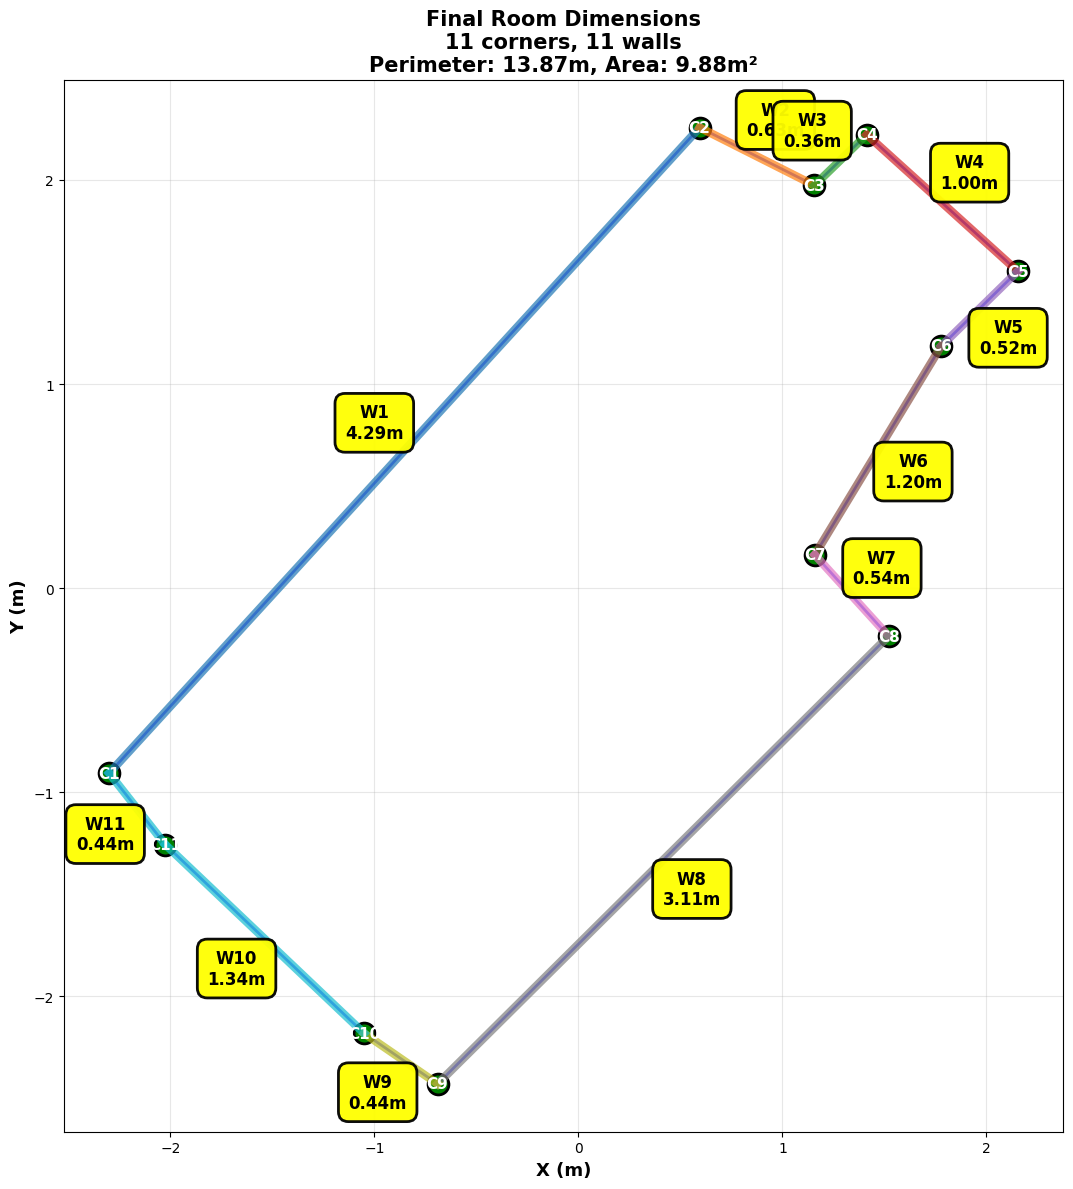

In [204]:
visualize_final_dimensions(final_walls)

In [74]:
import alphashape

In [75]:
def compute_concave_hull(points_2d, alpha=0.5):
    """
    Compute concave hull (alpha shape) of 2D points
    
    Args:
        points_2d: Nx2 numpy array of 2D points
        alpha: Alpha parameter controlling hull tightness
               - Smaller alpha (0.1-0.3): Tighter, more detailed hull (follows contours closely)
               - Medium alpha (0.5-0.8): Balanced
               - Larger alpha (1.0-2.0): Looser, more convex (smooths over gaps)
               - alpha → infinity: Becomes convex hull
    
    Returns:
        hull_polygon: Shapely Polygon object, or None if failed
    """
    
    print(f"\nComputing concave hull with alpha={alpha}...")
    print(f"Input: {len(points_2d)} points")
    
    try:
        # Compute alpha shape
        hull = alphashape.alphashape(points_2d, alpha)
        
        # Check result type
        if hull is None or hull.is_empty:
            print("Warning: Hull computation returned empty result")
            return None
        
        # Handle MultiPolygon (disconnected regions)
        if hull.geom_type == 'MultiPolygon':
            print(f"Warning: Got MultiPolygon with {len(list(hull.geoms))} parts")
            # Take the largest polygon
            polygons = list(hull.geoms)
            hull = max(polygons, key=lambda p: p.area)
            print(f"Selected largest polygon (area={hull.area:.2f} m²)")
        
        # Get hull info
        num_vertices = len(hull.exterior.coords) - 1  # -1 because first=last
        
        print(f"✓ Hull computed successfully")
        print(f"  Vertices: {num_vertices}")
        print(f"  Area: {hull.area:.2f} m²")
        print(f"  Perimeter: {hull.length:.2f} m")
        
        return hull
    
    except Exception as e:
        print(f"Error computing hull: {e}")
        return None

In [77]:
hull = compute_concave_hull(wall_points_2d)


Computing concave hull with alpha=0.5...
Input: 122367 points
✓ Hull computed successfully
  Vertices: 149
  Area: 12.33 m²
  Perimeter: 14.11 m


In [78]:
def visualize_hull(points_2d, hull_polygon, title="Concave Hull", downsample=10):
    """
    Visualize 2D points with hull overlay
    
    Args:
        points_2d: Nx2 numpy array of original points
        hull_polygon: Shapely Polygon from compute_concave_hull
        title: Plot title
        downsample: Downsample points for faster plotting
    """
    if hull_polygon is None:
        print("No hull to visualize")
        return
    
    # Downsample points
    if downsample > 1:
        points_to_plot = points_2d[::downsample]
    else:
        points_to_plot = points_2d
    
    # Extract hull vertices
    hull_coords = np.array(hull_polygon.exterior.coords)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot points
    ax.scatter(points_to_plot[:, 0], points_to_plot[:, 1], 
               s=1, c='lightblue', alpha=0.3, label='Wall points')
    
    # Plot hull
    ax.plot(hull_coords[:, 0], hull_coords[:, 1], 
            'r-', linewidth=2, label='Concave hull')
    ax.plot(hull_coords[:, 0], hull_coords[:, 1], 
            'ro', markersize=4, label='Hull vertices')
    
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_title(title)
    ax.axis('equal')
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    print(f"\nVisualization info:")
    print(f"  Plotted {len(points_to_plot)} points (downsampled from {len(points_2d)})")
    print(f"  Hull has {len(hull_coords)-1} vertices")

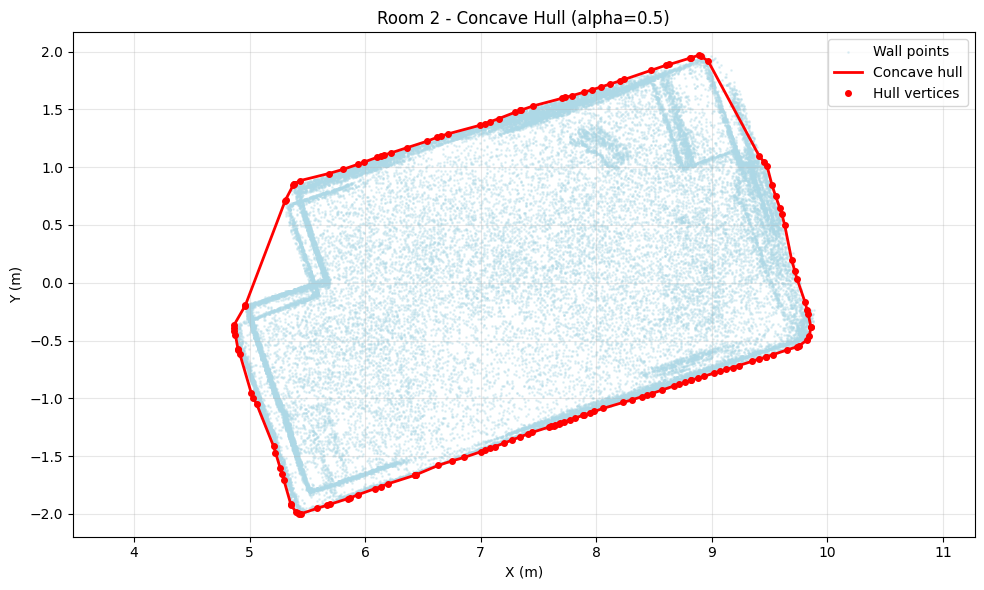


Visualization info:
  Plotted 42699 points (downsampled from 426989)
  Hull has 149 vertices


In [79]:
visualize_hull(points_2d, hull, title="Room 2 - Concave Hull (alpha=0.5)")

In [80]:
def compare_alpha_values(points_2d, alpha_values=[0.3, 0.5, 0.8, 1.0], downsample=10):
    """
    Compare different alpha values side-by-side
    
    Args:
        points_2d: Nx2 numpy array
        alpha_values: List of alpha values to test
        downsample: Downsample for plotting
    """
    
    # Downsample points
    if downsample > 1:
        points_to_plot = points_2d[::downsample]
    else:
        points_to_plot = points_2d
    
    num_alphas = len(alpha_values)
    fig, axes = plt.subplots(1, num_alphas, figsize=(6*num_alphas, 6))
    
    if num_alphas == 1:
        axes = [axes]
    
    for i, alpha in enumerate(alpha_values):
        ax = axes[i]
        
        # Compute hull
        hull = compute_concave_hull(points_2d, alpha=alpha)
        
        if hull is not None:
            # Plot points
            ax.scatter(points_to_plot[:, 0], points_to_plot[:, 1], 
                      s=1, c='lightblue', alpha=0.3)
            
            # Plot hull
            hull_coords = np.array(hull.exterior.coords)
            ax.plot(hull_coords[:, 0], hull_coords[:, 1], 'r-', linewidth=2)
            ax.plot(hull_coords[:, 0], hull_coords[:, 1], 'ro', markersize=3)
            
            ax.set_title(f'Alpha = {alpha}\n{len(hull_coords)-1} vertices, '
                        f'Area = {hull.area:.2f} m²')
        else:
            ax.set_title(f'Alpha = {alpha}\n(failed)')
        
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Y (m)')
        ax.axis('equal')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


Computing concave hull with alpha=0.05...
Input: 122367 points
✓ Hull computed successfully
  Vertices: 51
  Area: 12.42 m²
  Perimeter: 14.10 m


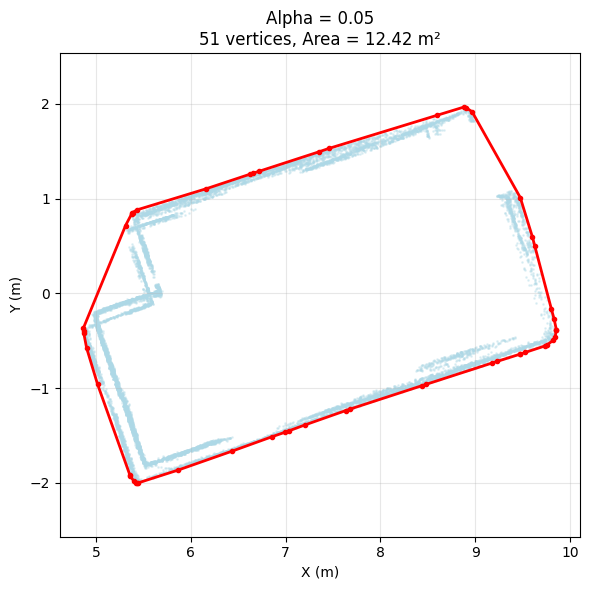

In [83]:
compare_alpha_values(wall_points_2d, alpha_values=[0.05])

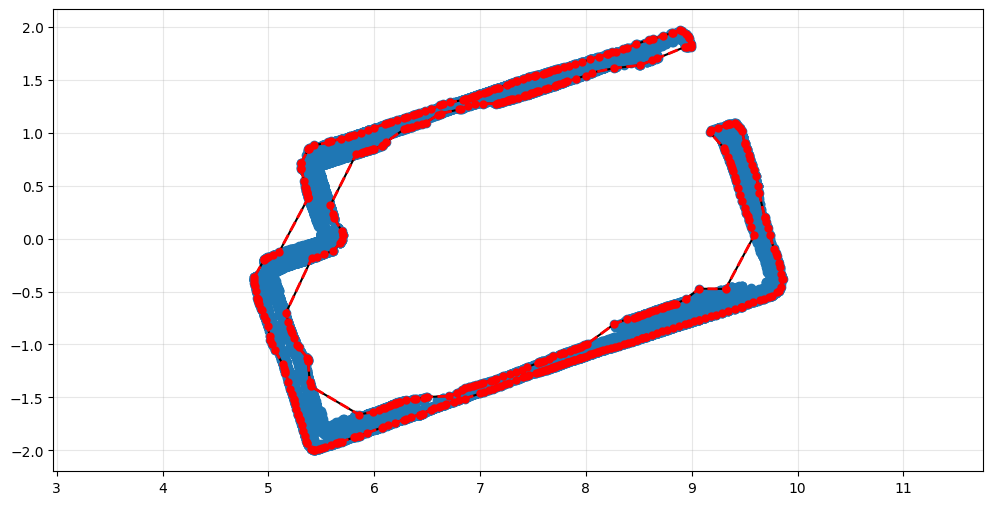

In [99]:
plt.figure(figsize=(12, 6))
plt.plot(wall_points_2d[:, 0], wall_points_2d[:, 1], 'o')

# Get alpha shape
alpha_hull = alpha_shape(wall_points_2d, alpha=0.4)

if alpha_hull.geom_type == 'Polygon':
    x, y = alpha_hull.exterior.xy
    coords = np.array(list(zip(x, y)))
    
    # Plot edges
    for i in range(len(coords) - 1):
        plt.plot([coords[i, 0], coords[i+1, 0]], 
                [coords[i, 1], coords[i+1, 1]], 'k-')
    
    # Plot vertices
    plt.plot(x, y, 'r--', lw=2, marker='o', markersize=5)

plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.show()

In [84]:
def display_inlier_outlier(cloud, ind):
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud],
                                      zoom=0.3412,
                                      front=[0.4257, -0.2125, -0.8795],
                                      lookat=[2.6172, 2.0475, 1.532],
                                      up=[-0.0694, -0.9768, 0.2024])

In [85]:
voxel_down_pcd = sem_seg.pcd

In [ ]:
(voxel_down_pcd.select_by_index(ind))

PointCloud with 410042 points.

In [91]:
cl, ind = voxel_down_pcd.remove_radius_outlier(nb_points=16, radius=0.05)
display_inlier_outlier(voxel_down_pcd, ind)

Showing outliers (red) and inliers (gray): 


In [94]:
o3d.visualization.draw_geometries([cl])

### pointnet

In [16]:
predictions = sem_seg.pointnet_segmentation(sem_seg.points, type='all')

In [17]:
sem_seg.visualize_segments(predictions)

PointCloud with 891428 points.

In [20]:
sem_seg.classes["ceiling"]

0

In [21]:
ceiling_mask = predictions == sem_seg.classes["ceiling"]
wall_mask = predictions == sem_seg.classes["wall"]
door_mask = predictions == sem_seg.classes["door"]
window_mask = predictions == sem_seg.classes["window"]

ceiling_points_2d = points_2d[ceiling_mask]
wall_points_2d = points_2d[wall_mask]
door_points_2d = points_2d[door_mask]
window_points_2d = points_2d[window_mask]

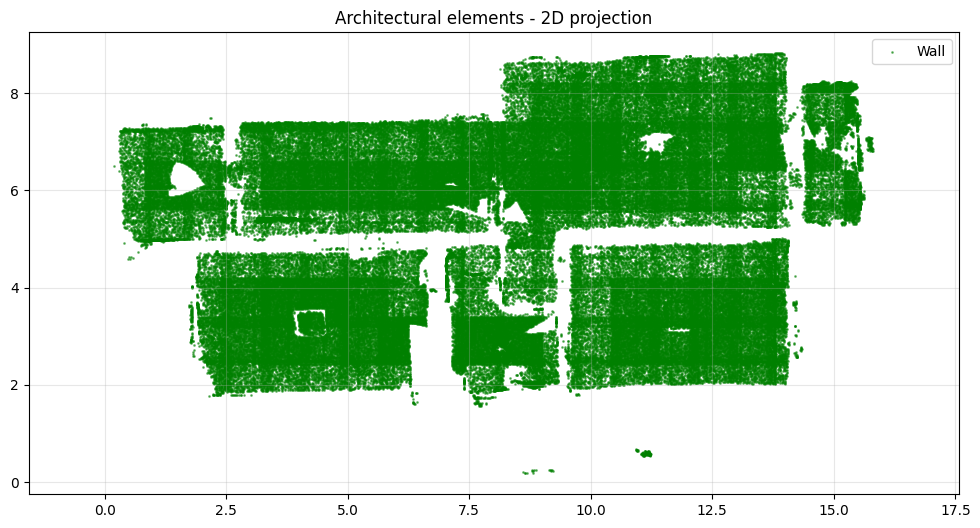

In [23]:
plt.figure(figsize=(12, 6))
plt.scatter(ceiling_points_2d[:, 0], ceiling_points_2d[:, 1], c='green', s=1, label='Wall', alpha=0.5)
# plt.scatter(wall_points_2d[:, 0], wall_points_2d[:, 1], c='gray', s=1, label='Wall', alpha=0.5)
# plt.scatter(window_points_2d[:, 0], window_points_2d[:, 1], c='cyan', s=2, label='Window')
# plt.scatter(door_points_2d[:, 0], door_points_2d[:, 1], c='red', s=2, label='Door')
plt.axis('equal')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title('Architectural elements - 2D projection')
plt.show()

In [116]:
clustering = DBSCAN(eps=0.1, min_samples=5, n_jobs=-1)  
ceiling_clusters = clustering.fit_predict(ceiling_points_2d)

In [121]:
n = len(set(ceiling_clusters)) - (1 if -1 in ceiling_clusters else 0)
print(f"Number of segments found: {n}")

Number of segments found: 16


In [122]:
ceiling_clusters

array([0, 0, 0, ..., 1, 1, 1], shape=(124351,))

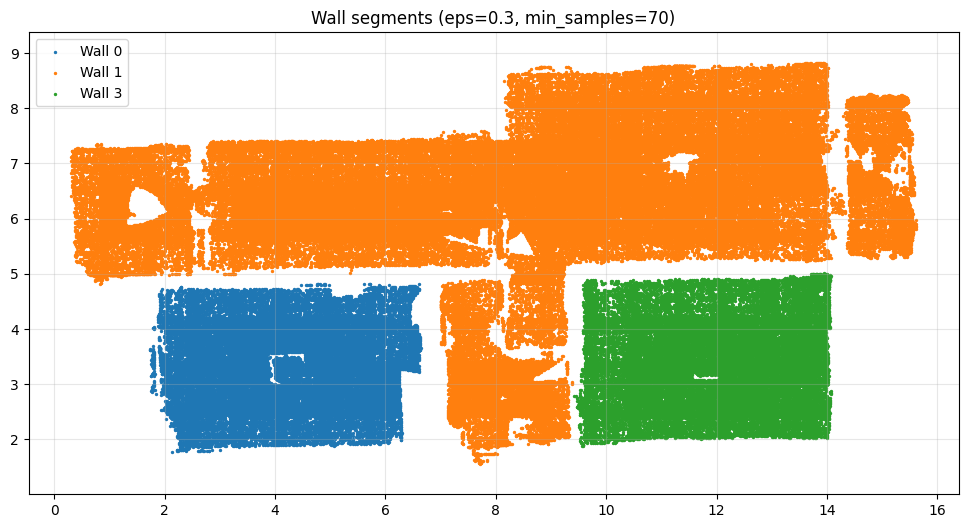

In [133]:
keep_clusters = []
plt.figure(figsize=(12, 6))
for cluster_id in set(ceiling_clusters):
    if cluster_id == -1:
        color = 'black'
        label = 'Noise'
    else:
        label = f'Wall {cluster_id}'
        color = None
    
    mask = ceiling_clusters == cluster_id
    if sum(mask) > 300:
        keep_clusters.append(cluster_id)
        plt.scatter(ceiling_points_2d[mask, 0], ceiling_points_2d[mask, 1], 
                    s=2, label=label, c=color if color else None)

plt.axis('equal')
plt.legend()
plt.title(f'Wall segments (eps=0.3, min_samples=70)')
plt.grid(True, alpha=0.3)
plt.show()

In [134]:
keep_clusters

[np.int64(0), np.int64(1), np.int64(3)]

In [146]:
mask = ceiling_clusters == keep_clusters[0]

In [147]:
sum(mask)

np.int64(22783)

In [148]:
coord = ceiling_points_2d[mask]

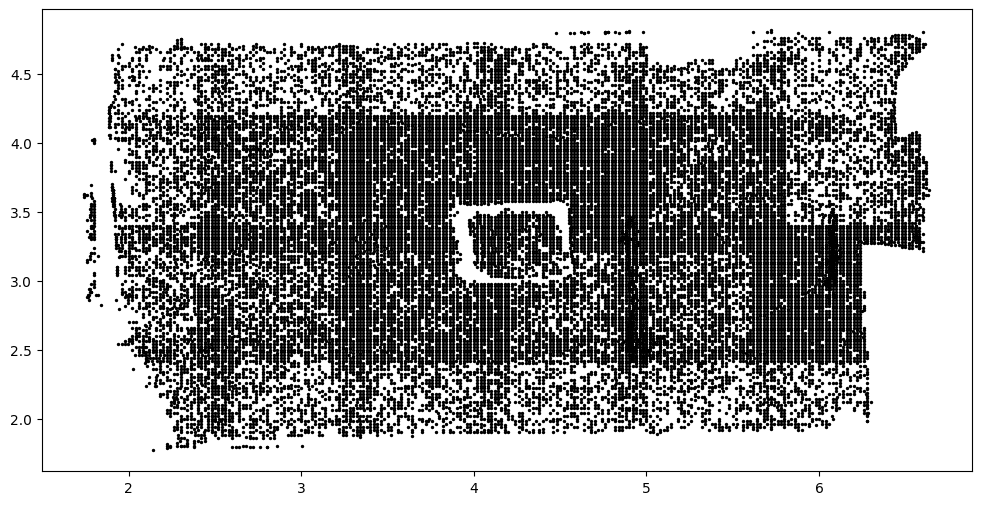

In [149]:
plt.figure(figsize=(12, 6))
plt.scatter(coord[:, 0], coord[:, 1], 
                    s=2, label=label, c=color if color else None)

In [144]:
def get_shape_dimensions_numpy(coordinates_array):
    if coordinates_array.size == 0:
        return 0, 0

    min_coords = np.min(coordinates_array, axis=0)
    max_coords = np.max(coordinates_array, axis=0)

    width = max_coords[0] - min_coords[0]
    height = max_coords[1] - min_coords[1]
    return width, height

In [145]:
get_shape_dimensions_numpy(coord)

(np.float64(4.670390605926514), np.float64(3.1399996876716614))

In [131]:
sum(mask)

np.int64(38)

In [ ]:
wall_indices = sem_seg.ransac_segmentor.segments['wall_pointnet']['indices']
# door_indices = sem_seg.ransac_segmentor.segments['door_pointnet']['indices']
# window_indices = sem_seg.ransac_segmentor.segments['window_pointnet']['indices']

print(f"Wall points: {len(wall_indices)}")
# print(f"Door points: {len(door_indices)}")
# print(f"Window points: {len(window_indices)}")

  

# Extract architectural points using indices
wall_points_2d = points_2d[wall_indices]
# door_points_2d = points_2d[door_indices]
# window_points_2d = points_2d[window_indices]

Wall points: 165476


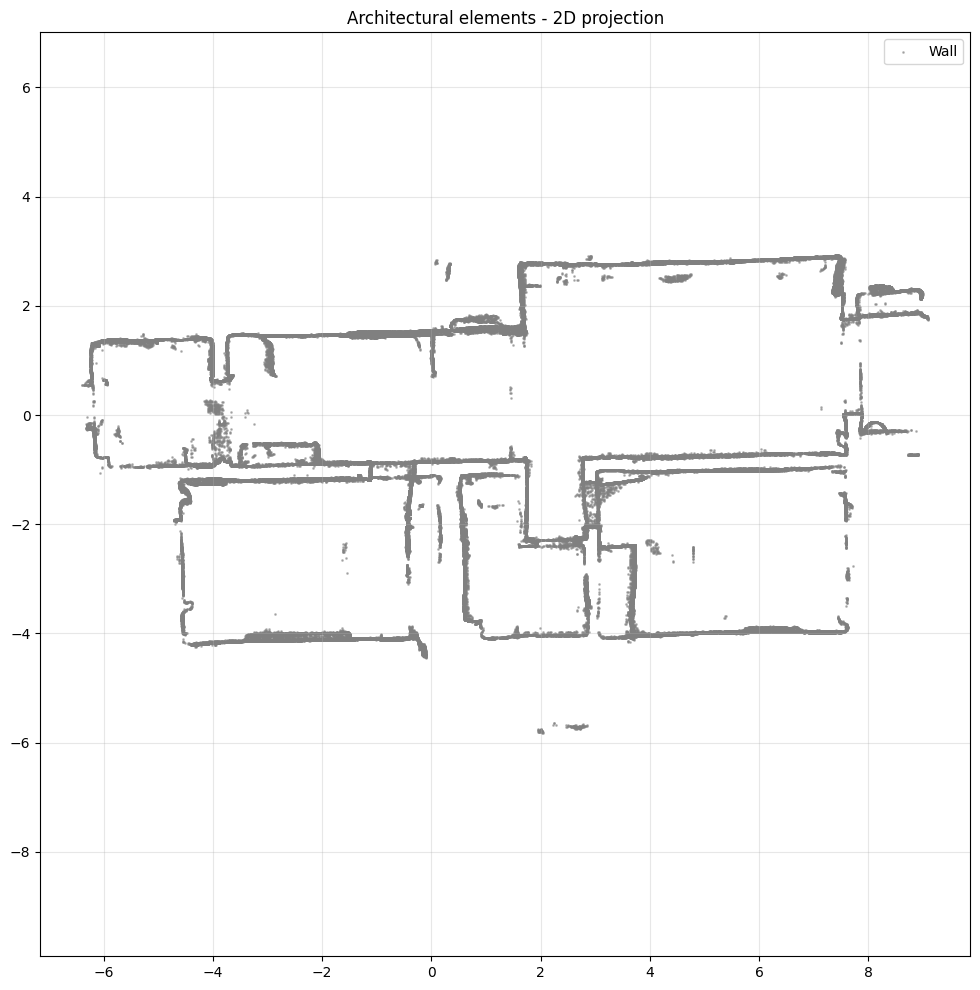

In [13]:
plt.figure(figsize=(12, 12))
plt.scatter(wall_points_2d[:, 0], wall_points_2d[:, 1], c='gray', s=1, label='Wall', alpha=0.5)
# plt.scatter(window_points_2d[:, 0], window_points_2d[:, 1], c='cyan', s=2, label='Window')
# plt.scatter(door_points_2d[:, 0], door_points_2d[:, 1], c='red', s=2, label='Door')
plt.axis('equal')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title('Architectural elements - 2D projection')
plt.show()

In [12]:
door_clusters = sem_seg.ransac_segmentor.cluster_points(door_indices, eps=0.5, )

In [13]:
for i, cluster in enumerate(door_clusters):
    print(i, len(cluster))

0 326
1 15
2 5062
3 12


In [14]:
door_indices_clustered = door_clusters[2]

In [15]:
wall_points_2d = points_2d[wall_indices]
door_points_2d = points_2d[door_indices_clustered]
# window_points_2d = points_2d[window_indices]

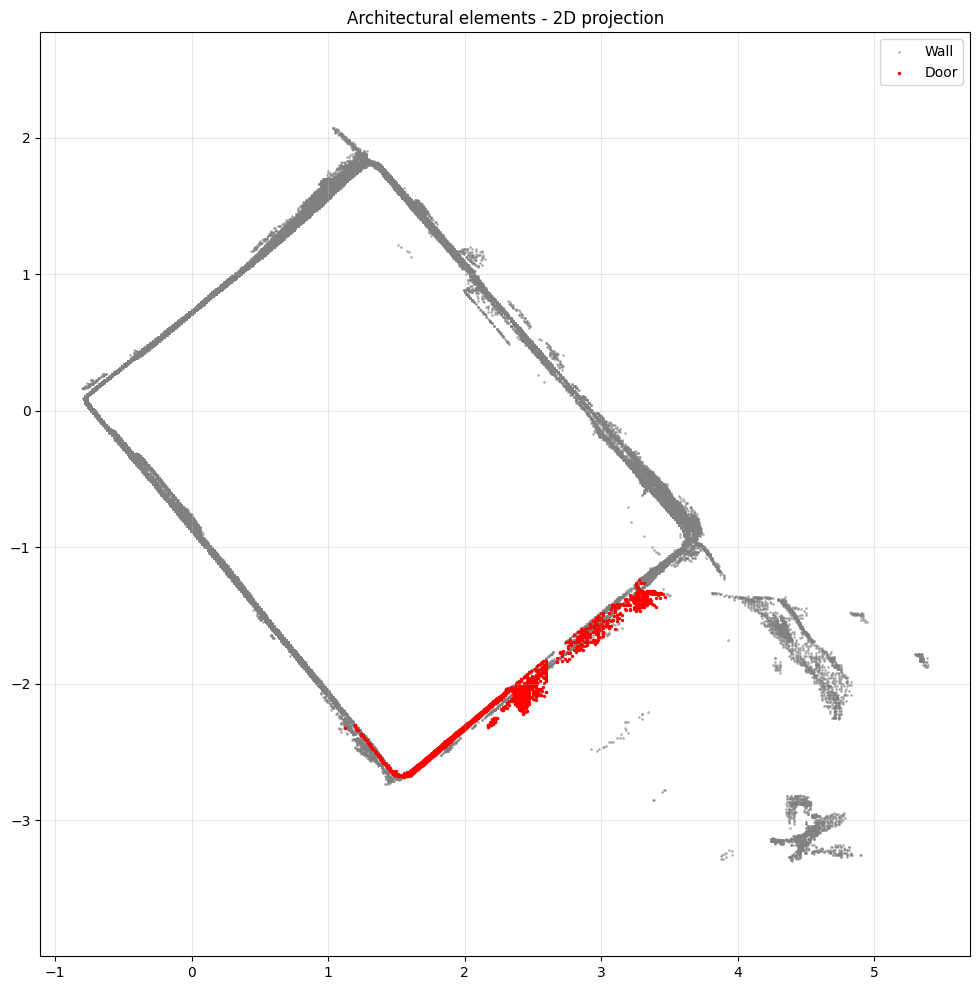

In [16]:
plt.figure(figsize=(12, 12))
plt.scatter(wall_points_2d[:, 0], wall_points_2d[:, 1], c='gray', s=1, label='Wall', alpha=0.5)
# plt.scatter(window_points_2d[:, 0], window_points_2d[:, 1], c='cyan', s=2, label='Window')
plt.scatter(door_points_2d[:, 0], door_points_2d[:, 1], c='red', s=2, label='Door')
plt.axis('equal')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title('Architectural elements - 2D projection')
plt.show()

In [34]:
segment_models = {}
segments_ransac = {}

epsilon = 0.15
min_cluster_points = 50
max_plane_idx = 30
distance_threshold = 0.1
rest = sem_seg.pcd
for i in range(max_plane_idx):
    # colors = plt.get_cmap("tab20")(i)
    segment_models[i], inliers = rest.segment_plane(distance_threshold=distance_threshold, ransac_n=3, num_iterations=2000)
    segments_ransac[i] = rest.select_by_index(inliers)
    labels = np.array(segments_ransac[i].cluster_dbscan(eps=epsilon, min_points=min_cluster_points))
    candidates = [len(np.where(labels == j)[0]) for j in np.unique(labels)]
    best_candidate = int(np.unique(labels)[np.where(candidates == np.max(candidates))[0]])
    rest = rest.select_by_index(inliers, invert=True) + segments_ransac[i].select_by_index(list(np.where(labels != best_candidate)[0]))
    segments_ransac[i] = segments_ransac[i].select_by_index(list(np.where(labels == best_candidate)[0]))
    colors = plt.get_cmap("tab20")(i)
    segments_ransac[i].paint_uniform_color(list(colors[:3]))
    # segments_ransac[i].paint_uniform_color(list(colors[:3]))
    # rest = rest.select_by_index(inliers, invert=True)
    
    # print("pass", i, "/", max_plane_idx, "done.")

/var/folders/j4/yzpk21j93c5bl_mjst9qb4mc0000gn/T/ipykernel_28967/882629629.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  best_candidate = int(np.unique(labels)[np.where(candidates == np.max(candidates))[0]])


In [35]:
o3d.visualization.draw_geometries([segments_ransac[i] for i in range(max_plane_idx)])

In [36]:
sem_seg.visualize_pcd()